In [393]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from joblib import Parallel, delayed


from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from hmmlearn.hmm import GaussianHMM, GMMHMM
from jumpmodels.jump import JumpModel  
from jumpmodels.sparse_jump import SparseJumpModel
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
import scipy.stats as st
np.random.seed(42)

# Full Sample Fitting

In [394]:
df = pd.read_csv(f"data/SPY_filter.csv", index_col="Date")
df = df[df.index > '1994-01-01']
df.index = pd.to_datetime(df.index)

features = ['SPY_ret_5', 'SPY_DD-log_5', 'SPY_sortino_5', 
            'SPY_ret_10', 'SPY_DD-log_10', 'SPY_sortino_10', 
            'SPY_ret_60', 'SPY_DD-log_60', 'SPY_sortino_60']

#df = df[df.index > '2015-01-01']
df2 = df.copy()

gmm = GaussianMixture(n_components=2, random_state=42)
kmeans = KMeans(n_clusters=2, random_state=42)
jm = JumpModel(n_components=2, jump_penalty=50, cont=False, random_state=42)
ghmm = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000, random_state=42)
gmmhmm = GMMHMM(n_components=2, covariance_type="full", n_iter=1000, random_state=42)
df2['GMM_Labels'] = gmm.fit_predict(df[features])

ghmm.fit(df[features].to_numpy())  
gmmhmm.fit(df[features].to_numpy())  
df2['GHMM_Labels'] = ghmm.predict(df[features].to_numpy())
df2['GMMHMM_Labels'] = gmmhmm.predict(df[features].to_numpy())
df2['KMeans_Labels'] = kmeans.fit_predict(df[features])
#df2['GMM_Labels'] = gmm.fit_predict(df[features])
jm.fit(df[features], df['SPY'], sort_by="cumret")
df2['JM_Labels'] = jm.predict(df[features])

df2



,SPY,SPY_ret_5,SPY_DD-log_5,SPY_sortino_5,SPY_ret_10,SPY_DD-log_10,SPY_sortino_10,SPY_ret_60,SPY_DD-log_60,SPY_sortino_60,GMM_Labels,GHMM_Labels,GMMHMM_Labels,KMeans_Labels,JM_Labels
Date,,,,,,,,,,,,,,,
1994-01-03,-0.005352,-0.000259,-5.846021,-0.089684,0.000134,-5.867807,0.047361,0.000337,-5.724098,0.103209,0,0,0,0,0
1994-01-04,-0.002685,-0.000573,-5.855000,-0.200085,-0.000055,-5.871135,-0.019438,0.000300,-5.726097,0.092001,0,0,0,0,0
1994-01-05,0.004027,0.000022,-5.924314,0.008279,0.000219,-5.905792,0.080232,0.000346,-5.732285,0.106722,0,0,0,0,0
1994-01-06,0.002007,0.000279,-5.993629,0.111846,0.000338,-5.940450,0.128574,0.000366,-5.738469,0.113724,0,0,0,0,0
1994-01-07,0.000000,0.000243,-6.062944,0.104356,0.000316,-5.975107,0.124194,0.000362,-5.744647,0.113024,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,-0.016091,-0.003729,-4.810449,-0.457861,-0.001847,-4.950406,-0.260909,0.000282,-5.103409,0.046452,1,1,1,1,0
2025-03-03,0.015485,-0.001242,-4.879764,-0.163405,-0.000687,-4.985063,-0.100402,0.000457,-5.109186,0.075627,1,1,1,1,0
2025-03-04,-0.017675,-0.003369,-4.653928,-0.353733,-0.001824,-4.823915,-0.227043,0.000249,-5.067547,0.039473,1,1,1,1,0


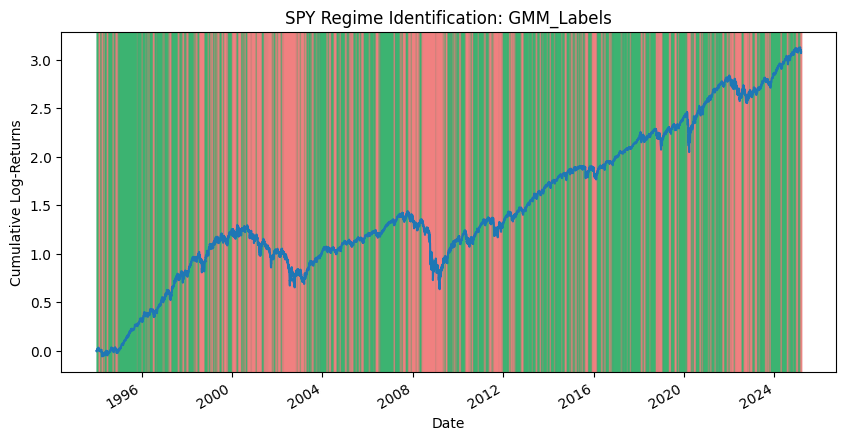

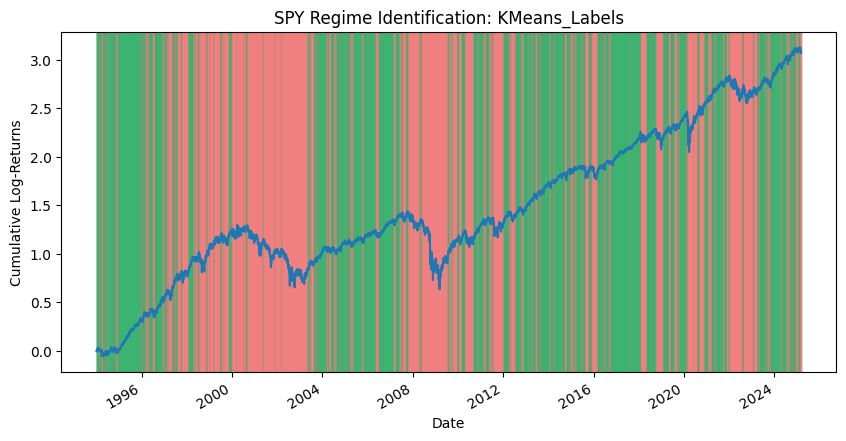

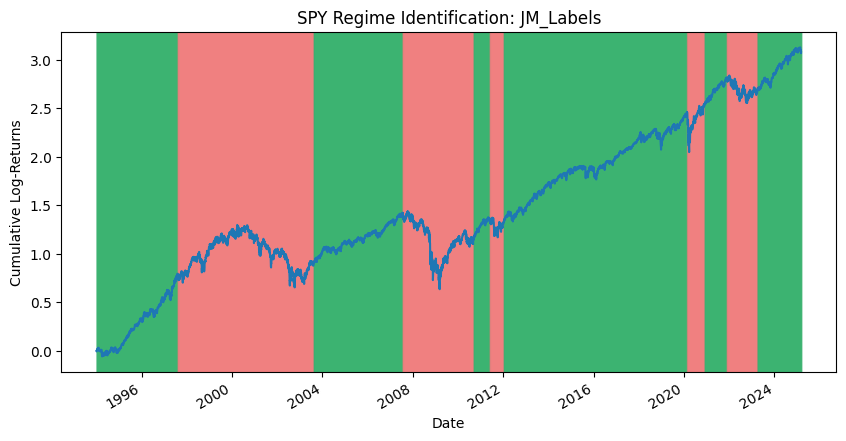

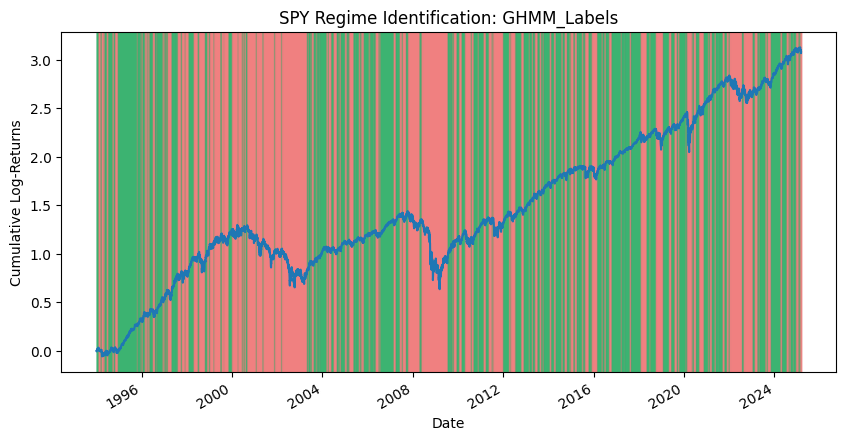

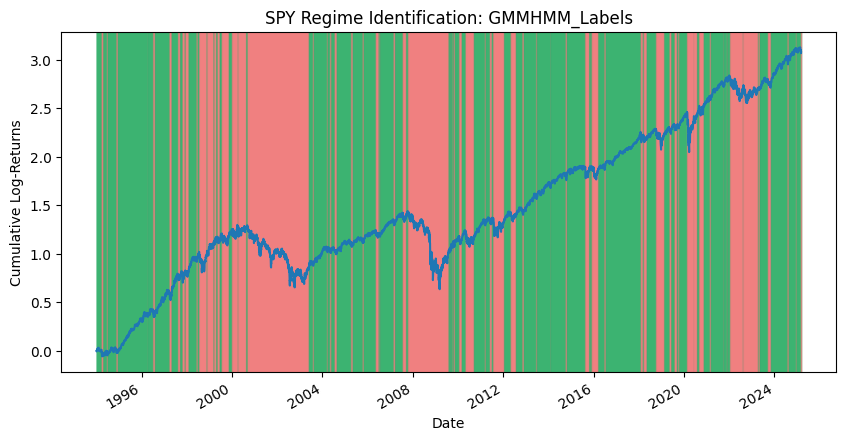

In [395]:

for column in ["GMM_Labels", "KMeans_Labels", "JM_Labels", "GHMM_Labels", "GMMHMM_Labels"]:

    
    plt.figure(figsize=(10, 5))
    df['SPY'].cumsum().plot()  
    for i in range(len(df['SPY']) - 1):
        start_date = df.index[i]
        end_date = df.index[i + 1]

        if column in ["GMM_Labels", "JM_Labels", "KMeans_Labels", "GHMM_Labels", "GMMHMM_Labels"]:

            color = 'lightcoral' if df2[column].iloc[i] == 1 else 'mediumseagreen'
        else:
            color = 'lightcoral' if df2[column].iloc[i] == 0 else 'mediumseagreen'

        plt.axvspan(start_date, end_date, color=color, alpha=0.3)
        plt.title(f"SPY Regime Identification: {column}")
        plt.ylabel("Cumulative Log-Returns")

plt.show()

# Count Regime Changes

In [396]:
df3 = df2[["GMM_Labels", "KMeans_Labels", "JM_Labels", "GHMM_Labels", "GMMHMM_Labels"]].copy()
shifts = []
# gmm_shifts = np.sum(df3['GMM_Labels'].diff().abs())
# kmeans_shifts = np.sum(df3['KMeans_Labels'].diff().abs())
# JM_shifts = np.sum(df3['JM_Labels'].diff().abs())
# GHMM_shifts = np.sum(df3['GHMM_Labels'].diff().abs())
# GMMHMM_shifts = np.sum(df3['GMMHMM_Labels'].diff().abs())

shifts.append(np.sum(df3['GMM_Labels'].diff().abs()))
shifts.append(np.sum(df3['KMeans_Labels'].diff().abs()))
shifts.append(np.sum(df3['JM_Labels'].diff().abs()))
shifts.append(np.sum(df3['GHMM_Labels'].diff().abs()))
shifts.append(np.sum(df3['GMMHMM_Labels'].diff().abs()))

regime_dict = {i:j for i, j in zip(df3.columns, shifts)}
regime_dict

{'GMM_Labels': 665.0,
 'KMeans_Labels': 473.0,
 'JM_Labels': 10.0,
 'GHMM_Labels': 285.0,
 'GMMHMM_Labels': 131.0}

In [397]:
yearly_conversion = len(df3) / 252
yearly_regime_dict = {i:j/yearly_conversion for i, j in zip(df3.columns, shifts)}
yearly_regime_dict

{'GMM_Labels': 21.35593220338983,
 'KMeans_Labels': 15.190008920606601,
 'JM_Labels': 0.32114183764495985,
 'GHMM_Labels': 9.152542372881356,
 'GMMHMM_Labels': 4.206958073148974}

# Rolling Window / Online Inference

In [398]:
def average_regime_length(series):
    """Calculate average regime length for a binary series of 0s and 1s."""
    changes = series.ne(series.shift())  # Identify where the regime changes
    group_sizes = series.groupby(changes.cumsum()).count()  # Count consecutive values
    return group_sizes.mean()  # Compute the average regime length

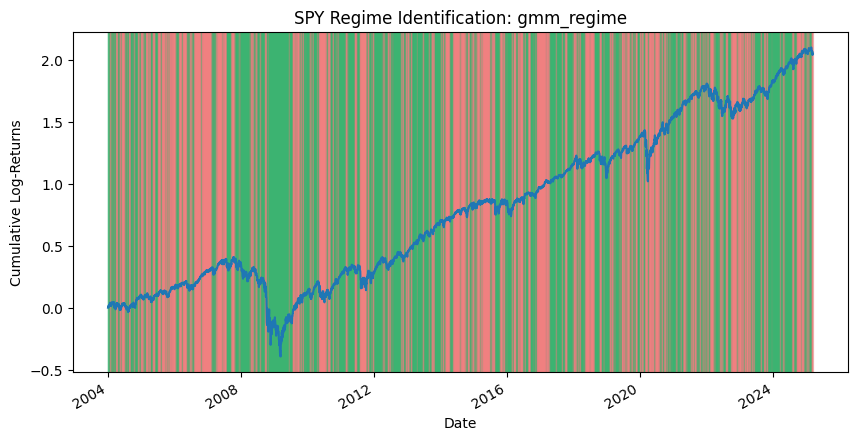

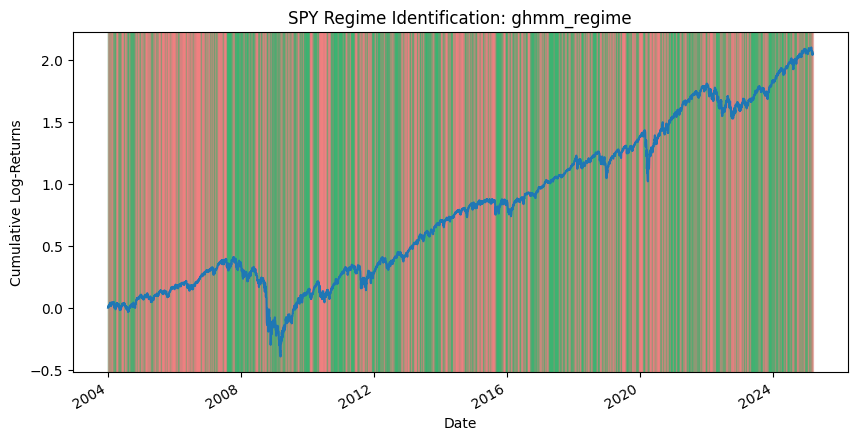

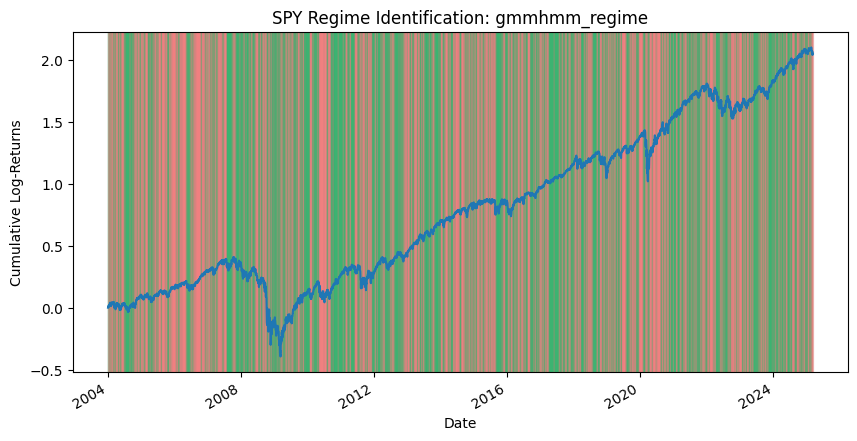

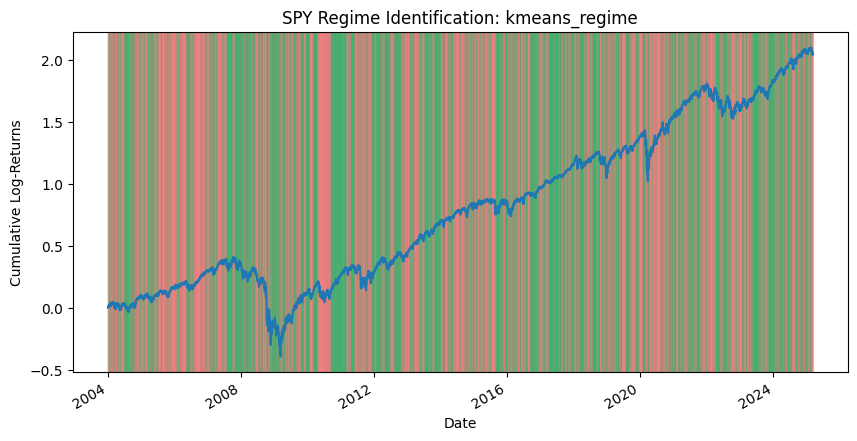

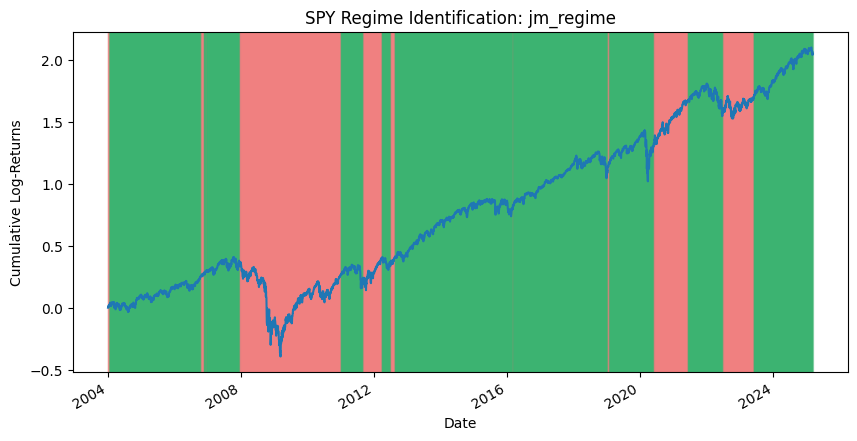

In [399]:
df6 = pd.read_csv(f"data/src.csv", index_col="Date")
#df6 = df6[df6.index > '1994-01-01']
df6.index = pd.to_datetime(df6.index)
for column in ["gmm_regime", "ghmm_regime", "gmmhmm_regime", "kmeans_regime", "jm_regime"]:

    
    plt.figure(figsize=(10, 5))
    df6['SPY'].cumsum().plot()  
    for i in range(len(df6['SPY']) - 1):
        start_date = df6.index[i]
        end_date = df6.index[i + 1]

        if column in ["gmm_regime", "ghmm_regime", "gmmhmm_regime", "kmeans_regime", "jm_regime"]:

            color = 'lightcoral' if df6[column].iloc[i] == 1 else 'mediumseagreen'
        else:
            color = 'lightcoral' if df6[column].iloc[i] == 0 else 'mediumseagreen'

        plt.axvspan(start_date, end_date, color=color, alpha=0.3)
        plt.title(f"SPY Regime Identification: {column}")
        plt.ylabel("Cumulative Log-Returns")

plt.show()

gmm_regime Sharpe: 0.42576346561208056
ghmm_regime Sharpe: 0.48057852344142304
gmmhmm_regime Sharpe: 0.4784532531520864
kmeans_regime Sharpe: 0.46252367957855345
jm_regime Sharpe: 0.48805398085612484
SPY Sharpe: 0.5185891838603587


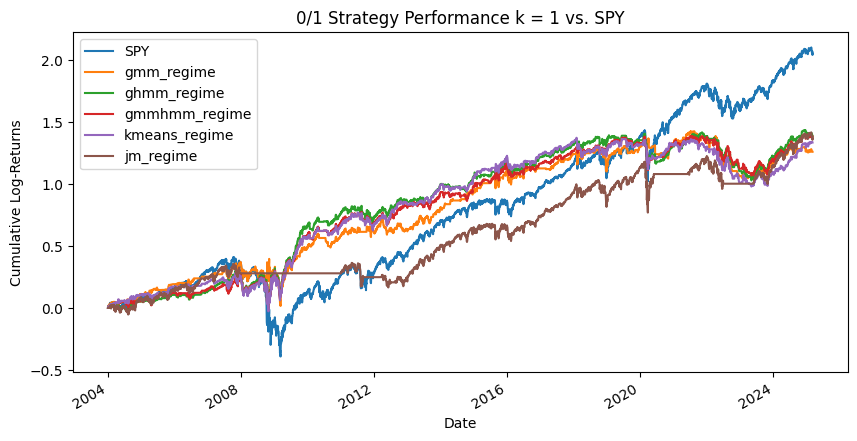

In [400]:
gmm_port = []
port = {i:[] for i in ["gmm_regime", "ghmm_regime", "gmmhmm_regime", "kmeans_regime", "jm_regime"]}

for i in range(len(df6)):
    for j in port:
        if j in ["gmm_regime", "ghmm_regime", "gmmhmm_regime", "kmeans_regime", "jm_regime"]:

            if df6[j].iloc[i] == 0:
                daily_return = df6['SPY'].iloc[i]
            else:
                daily_return = 0 
        else:
            if df6[j].iloc[i] == 1:
                daily_return = df6['SPY'].iloc[i]
            else:
                daily_return = 0 

        port[j].append(daily_return)


port = pd.DataFrame(port, index=df6.index)


# # print("\nPortfolio Returns:")
# # port_results

#df = df.loc["2015-01-01":]
plt.figure(figsize=(10, 5))
plt.ylabel("Cumulative Log-Returns")
plt.title("0/1 Strategy Performance k = 1 vs. SPY")
#portfolio_results['Portfolio'].cumsum().plot()
df6['SPY'].cumsum().plot()
for i in port.columns:
    port[i].cumsum().plot()
    print(f"{i} Sharpe:", np.sqrt(252) * port[i].mean()/port[i].std())

plt.legend()
print("SPY Sharpe:", np.sqrt(252) * df6['SPY'].mean()/df6['SPY'].std())
plt.show()

In [401]:
df6_5 = df6[["gmm_regime", "ghmm_regime", "gmmhmm_regime", "kmeans_regime", "jm_regime"]].copy()
shifts = []
# gmm_shifts = np.sum(df6_5['GMM_Labels'].diff().abs())
# kmeans_shifts = np.sum(df6_5['KMeans_Labels'].diff().abs())
# JM_shifts = np.sum(df6_5['JM_Labels'].diff().abs())
# GHMM_shifts = np.sum(df6_5['GHMM_Labels'].diff().abs())
# GMMHMM_shifts = np.sum(df6_5['GMMHMM_Labels'].diff().abs())

shifts.append(np.sum(df6_5['gmm_regime'].diff().abs()))
shifts.append(np.sum(df6_5['ghmm_regime'].diff().abs()))
shifts.append(np.sum(df6_5['gmmhmm_regime'].diff().abs()))
shifts.append(np.sum(df6_5['kmeans_regime'].diff().abs()))
shifts.append(np.sum(df6_5['jm_regime'].diff().abs()))

regime_dict = {i:j for i, j in zip(df6_5.columns, shifts)}
regime_dict




{'gmm_regime': 677.0,
 'ghmm_regime': 1339.0,
 'gmmhmm_regime': 1379.0,
 'kmeans_regime': 1443.0,
 'jm_regime': 19.0}

In [402]:
yearly_conversion = len(df6_5) / 252
yearly_regime_dict = {i:j/yearly_conversion for i, j in zip(df6_5.columns, shifts)}
yearly_regime_dict

{'gmm_regime': 32.020270270270274,
 'ghmm_regime': 63.33108108108108,
 'gmmhmm_regime': 65.22297297297297,
 'kmeans_regime': 68.25,
 'jm_regime': 0.8986486486486487}

In [403]:
average_lengths = df6_5.apply(average_regime_length)
average_lengths

gmm_regime         7.858407
ghmm_regime        3.976119
gmmhmm_regime      3.860870
kmeans_regime      3.689751
jm_regime        266.400000
dtype: float64

In [404]:
# df7 = pd.read_csv(f"data/src_less_features.csv", index_col="Date")
# #df7 = df7[df7.index > '1994-01-01']
# df7.index = pd.to_datetime(df7.index)
# for column in ["gmm_regime", "ghmm_regime", "gmmhmm_regime", "kmeans_regime", "jm_regime"]:

    
#     plt.figure(figsize=(10, 5))
#     df7['SPY'].cumsum().plot()  
#     for i in range(len(df7['SPY']) - 1):
#         start_date = df7.index[i]
#         end_date = df7.index[i + 1]

#         if column in ["ghmm_regime", "gmmhmm_regime", "kmeans_regime", "jm_regime"]:

#             color = 'lightcoral' if df7[column].iloc[i] == 1 else 'mediumseagreen'
#         else:
#             color = 'lightcoral' if df7[column].iloc[i] == 0 else 'mediumseagreen'

#         plt.axvspan(start_date, end_date, color=color, alpha=0.3)
#         plt.title(f"SPY Regime Identification: {column}")
#         plt.ylabel("Cumulative Log-Returns")

# plt.show()

In [405]:
# df7_5 = df7[["gmm_regime", "ghmm_regime", "gmmhmm_regime", "kmeans_regime", "jm_regime"]].copy()
# shifts = []
# # gmm_shifts = np.sum(df7_5['GMM_Labels'].diff().abs())
# # kmeans_shifts = np.sum(df7_5['KMeans_Labels'].diff().abs())
# # JM_shifts = np.sum(df7_5['JM_Labels'].diff().abs())
# # GHMM_shifts = np.sum(df7_5['GHMM_Labels'].diff().abs())
# # GMMHMM_shifts = np.sum(df7_5['GMMHMM_Labels'].diff().abs())

# shifts.append(np.sum(df7_5['gmm_regime'].diff().abs()))
# shifts.append(np.sum(df7_5['ghmm_regime'].diff().abs()))
# shifts.append(np.sum(df7_5['gmmhmm_regime'].diff().abs()))
# shifts.append(np.sum(df7_5['kmeans_regime'].diff().abs()))
# shifts.append(np.sum(df7_5['jm_regime'].diff().abs()))

# regime_dict = {i:j for i, j in zip(df7_5.columns, shifts)}
# regime_dict


In [406]:
# yearly_conversion = len(df7_5) / 252
# yearly_regime_dict = {i:j/yearly_conversion for i, j in zip(df7_5.columns, shifts)}
# yearly_regime_dict

In [407]:
# average_lengths = df7_5.apply(average_regime_length)
# average_lengths

# Filtering

In [408]:
df8 = df6[['SPY', 'gmm_regime', 'ghmm_regime', 'gmmhmm_regime', 'kmeans_regime', 'jm_regime']].copy()
window_size = 5

df8["gmm_filter"] = round(df8["gmm_regime"].rolling(window=window_size, min_periods=1).mean())
df8["ghmm_filter"] = round(df8["ghmm_regime"].rolling(window=window_size, min_periods=1).mean())
df8["gmmhmm_filter"] = round(df8["gmmhmm_regime"].rolling(window=window_size, min_periods=1).mean())
df8["kmeans_filter"] = round(df8["kmeans_regime"].rolling(window=window_size, min_periods=1).mean())
df8["jm_filter"] = round(df8["jm_regime"].rolling(window=window_size, min_periods=1).mean())

df8 = df8.dropna()
df8


,SPY,gmm_regime,ghmm_regime,gmmhmm_regime,kmeans_regime,jm_regime,gmm_filter,ghmm_filter,gmmhmm_filter,kmeans_filter,jm_filter
Date,,,,,,,,,,,
2004-01-02,0.000900,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2004-01-05,-0.000450,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2004-01-06,0.010820,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2004-01-07,0.000977,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2004-01-08,0.003371,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,-0.016091,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2025-03-03,0.015485,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2025-03-04,-0.017675,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


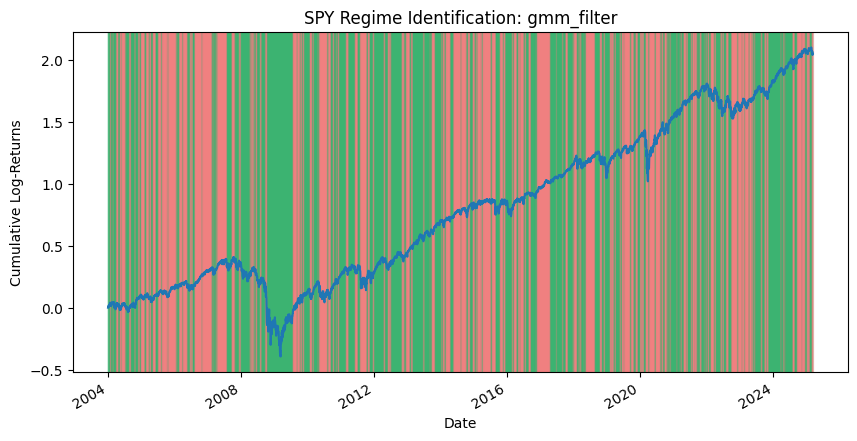

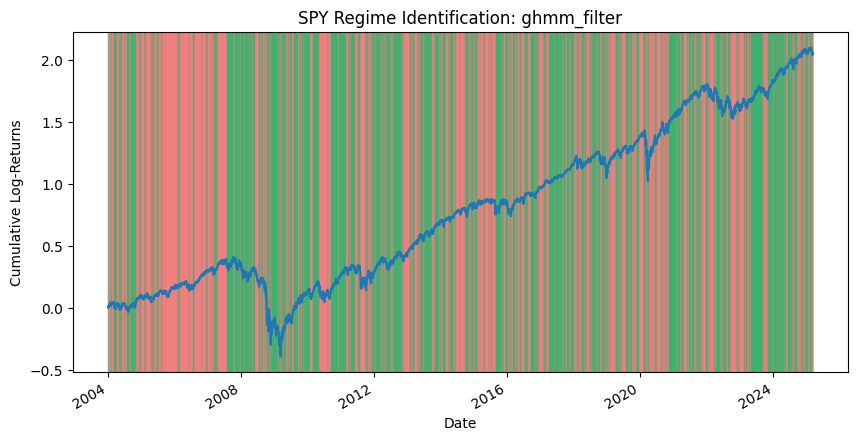

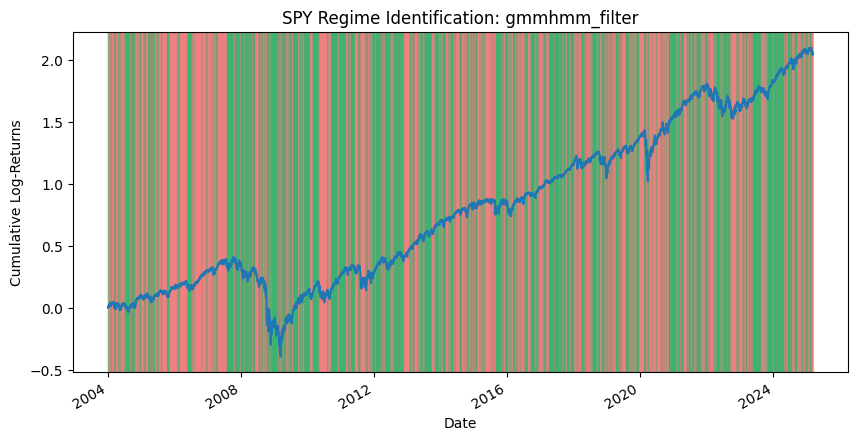

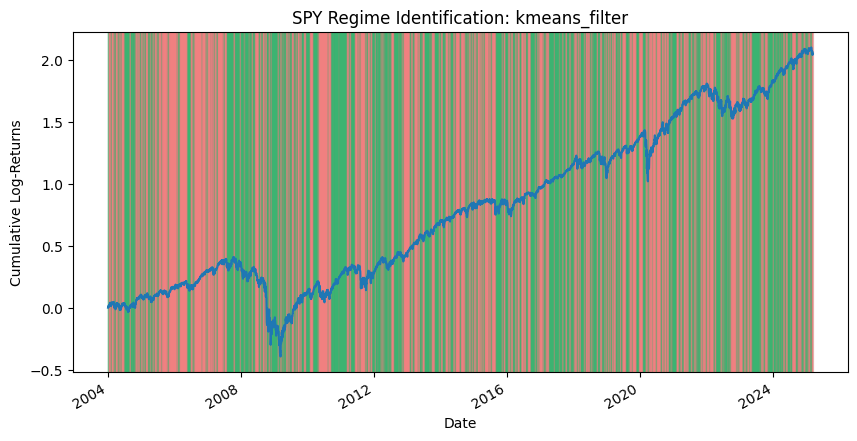

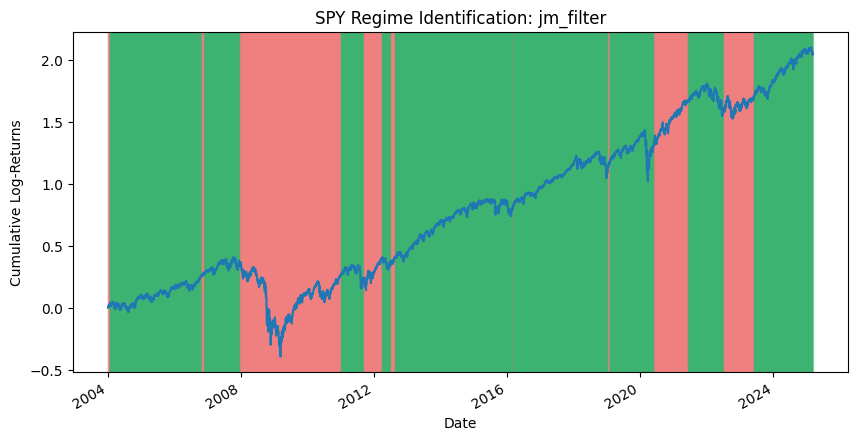

In [409]:

df8.index = pd.to_datetime(df8.index)

for column in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

    
    plt.figure(figsize=(10, 5))
    df8['SPY'].cumsum().plot()  
    for i in range(len(df8['SPY']) - 1):
        start_date = df8.index[i]
        end_date = df8.index[i + 1]

        if column in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

            color = 'lightcoral' if df8[column].iloc[i] == 1 else 'mediumseagreen'
        else:
            color = 'lightcoral' if df8[column].iloc[i] == 0 else 'mediumseagreen'

        plt.axvspan(start_date, end_date, color=color, alpha=0.3)
        plt.title(f"SPY Regime Identification: {column}")
        plt.ylabel("Cumulative Log-Returns")

plt.show()

gmm_filter Sharpe: 0.41460106621258086
ghmm_filter Sharpe: 0.41237483423674337
gmmhmm_filter Sharpe: 0.42269749913092747
kmeans_filter Sharpe: 0.4528747935280304
jm_filter Sharpe: 0.48333653942702665
SPY Sharpe: 0.5185891838603587


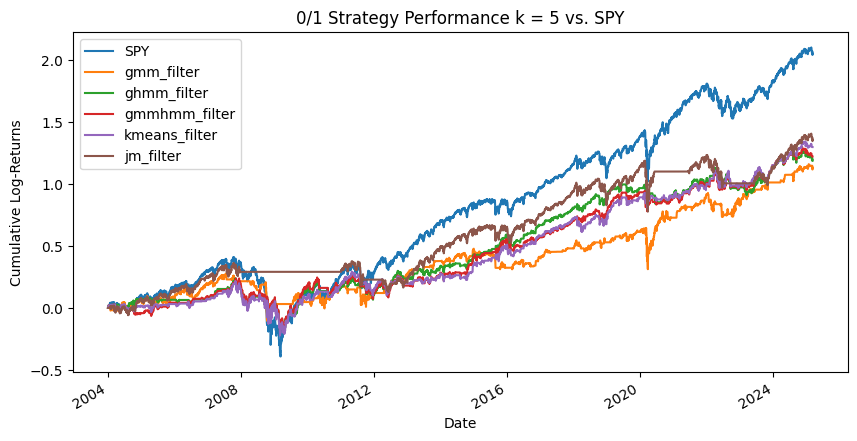

In [410]:
gmm_port = []
port = {i:[] for i in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]}

for i in range(len(df8)):
    for j in port:
        if j in ["ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

            if df8[j].iloc[i] == 0:
                daily_return = df8['SPY'].iloc[i]
            else:
                daily_return = 0 
        else:
            if df8[j].iloc[i] == 1:
                daily_return = df8['SPY'].iloc[i]
            else:
                daily_return = 0 

        port[j].append(daily_return)


port = pd.DataFrame(port, index=df8.index)


# # print("\nPortfolio Returns:")
# # port_results

#df = df.loc["2015-01-01":]
plt.figure(figsize=(10, 5))
plt.ylabel("Cumulative Log-Returns")
plt.title("0/1 Strategy Performance k = 5 vs. SPY")
#portfolio_results['Portfolio'].cumsum().plot()
df8['SPY'].cumsum().plot()
for i in port.columns:
    port[i].cumsum().plot()
    print(f"{i} Sharpe:", np.sqrt(252) * port[i].mean()/port[i].std())

plt.legend()
print("SPY Sharpe:", np.sqrt(252) * df8['SPY'].mean()/df8['SPY'].std())
plt.show()

In [411]:
df8_5 = df8[["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]].copy()
shifts = []
# gmm_shifts = np.sum(df8_5['GMM_Labels'].diff().abs())
# kmeans_shifts = np.sum(df8_5['KMeans_Labels'].diff().abs())
# JM_shifts = np.sum(df8_5['JM_Labels'].diff().abs())
# GHMM_shifts = np.sum(df8_5['GHMM_Labels'].diff().abs())
# GMMHMM_shifts = np.sum(df8_5['GMMHMM_Labels'].diff().abs())

shifts.append(np.sum(df8_5['gmm_filter'].diff().abs()))
shifts.append(np.sum(df8_5['ghmm_filter'].diff().abs()))
shifts.append(np.sum(df8_5['gmmhmm_filter'].diff().abs()))
shifts.append(np.sum(df8_5['kmeans_filter'].diff().abs()))
shifts.append(np.sum(df8_5['jm_filter'].diff().abs()))

regime_dict = {i:j for i, j in zip(df8_5.columns, shifts)}
regime_dict




{'gmm_filter': 325.0,
 'ghmm_filter': 491.0,
 'gmmhmm_filter': 507.0,
 'kmeans_filter': 525.0,
 'jm_filter': 17.0}

In [412]:
yearly_conversion = len(df8_5) / 252
yearly_regime_dict = {i:j/yearly_conversion for i, j in zip(df8_5.columns, shifts)}
yearly_regime_dict

{'gmm_filter': 15.371621621621623,
 'ghmm_filter': 23.222972972972972,
 'gmmhmm_filter': 23.97972972972973,
 'kmeans_filter': 24.83108108108108,
 'jm_filter': 0.8040540540540541}

In [413]:
average_lengths = df8_5.apply(average_regime_length)
average_lengths

gmm_filter        16.343558
ghmm_filter       10.829268
gmmhmm_filter     10.488189
kmeans_filter     10.129278
jm_filter        296.000000
dtype: float64

In [414]:
df9 = df6[['SPY', 'gmm_regime', 'ghmm_regime', 'gmmhmm_regime', 'kmeans_regime', 'jm_regime']].copy()
window_size = 12

df9["gmm_filter"] = round(df9["gmm_regime"].rolling(window=window_size, min_periods=1).mean())
df9["ghmm_filter"] = round(df9["ghmm_regime"].rolling(window=window_size, min_periods=1).mean())
df9["gmmhmm_filter"] = round(df9["gmmhmm_regime"].rolling(window=window_size, min_periods=1).mean())
df9["kmeans_filter"] = round(df9["kmeans_regime"].rolling(window=window_size, min_periods=1).mean())
df9["jm_filter"] = round(df9["jm_regime"].rolling(window=window_size, min_periods=1).mean())

df9 = df9.dropna()
df9


,SPY,gmm_regime,ghmm_regime,gmmhmm_regime,kmeans_regime,jm_regime,gmm_filter,ghmm_filter,gmmhmm_filter,kmeans_filter,jm_filter
Date,,,,,,,,,,,
2004-01-02,0.000900,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2004-01-05,-0.000450,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2004-01-06,0.010820,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2004-01-07,0.000977,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2004-01-08,0.003371,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,-0.016091,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2025-03-03,0.015485,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2025-03-04,-0.017675,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


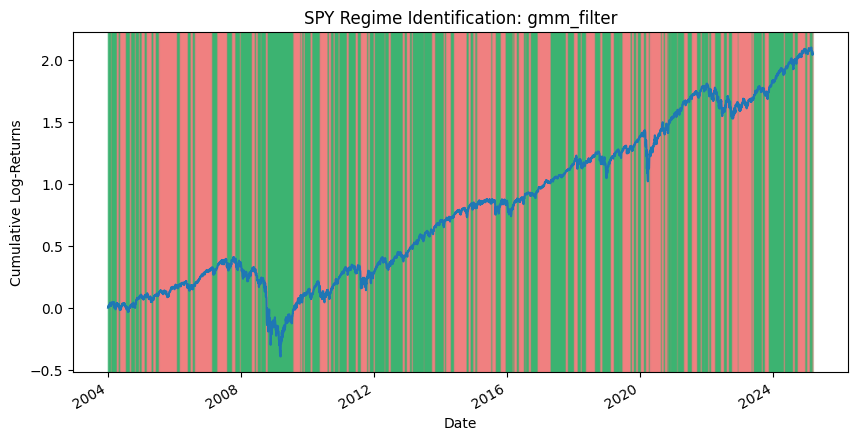

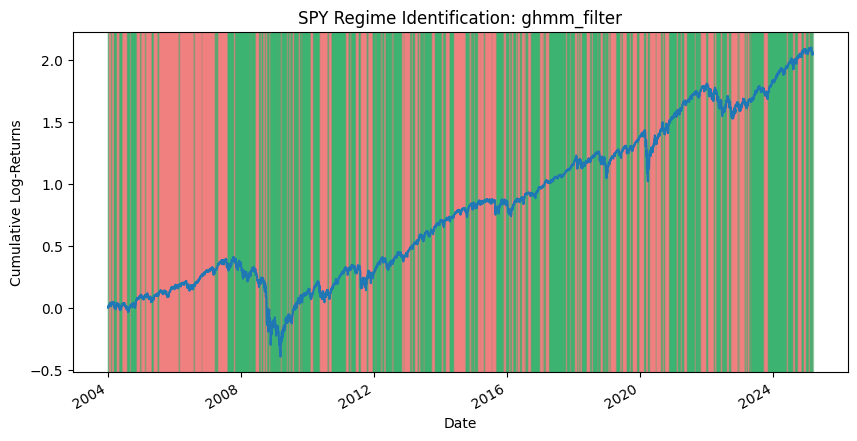

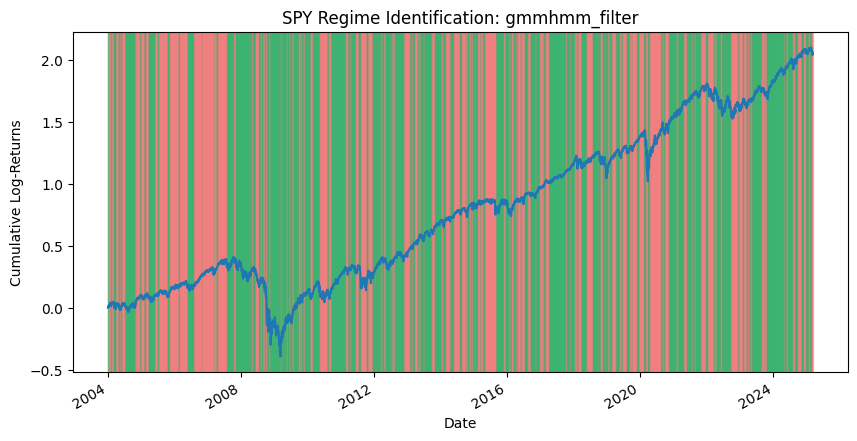

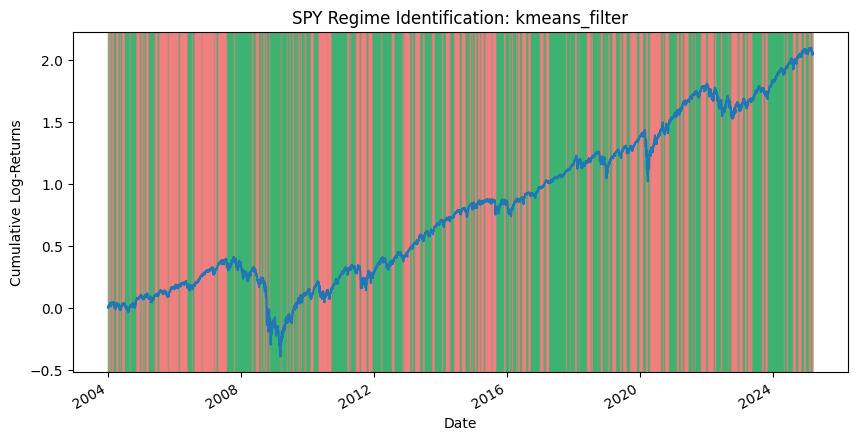

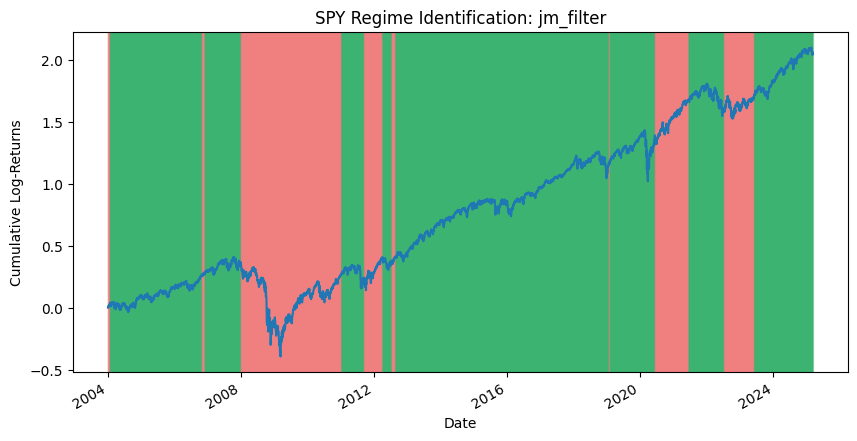

In [415]:

df9.index = pd.to_datetime(df9.index)
for column in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

    
    plt.figure(figsize=(10, 5))
    df9['SPY'].cumsum().plot()  
    for i in range(len(df9['SPY']) - 1):
        start_date = df9.index[i]
        end_date = df9.index[i + 1]

        if column in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

            color = 'lightcoral' if df9[column].iloc[i] == 1 else 'mediumseagreen'
        else:
            color = 'lightcoral' if df9[column].iloc[i] == 0 else 'mediumseagreen'

        plt.axvspan(start_date, end_date, color=color, alpha=0.3)
        plt.title(f"SPY Regime Identification: {column}")
        plt.ylabel("Cumulative Log-Returns")

plt.show()

gmm_filter Sharpe: 0.387067348270273
ghmm_filter Sharpe: 0.6534323623823832
gmmhmm_filter Sharpe: 0.6428604244706282
kmeans_filter Sharpe: 0.595119765741069
jm_filter Sharpe: 0.5090770709899696
SPY Sharpe: 0.5185891838603587


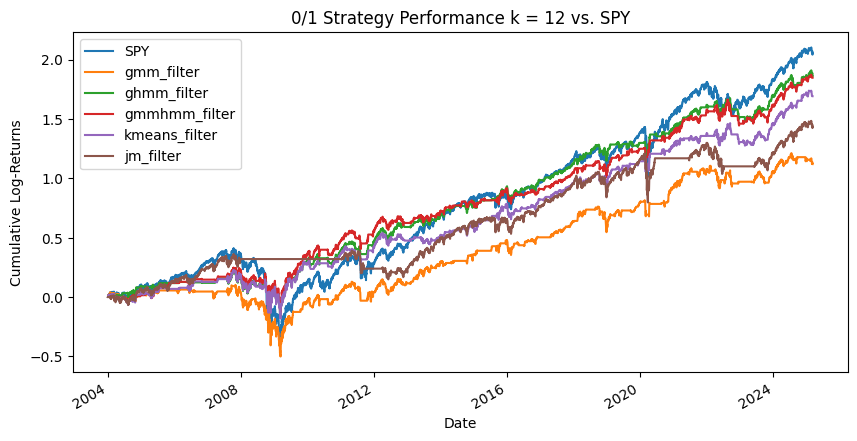

In [416]:
gmm_port = []
port = {i:[] for i in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]}

for i in range(len(df9)):
    for j in port:
        if j in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

            if df9[j].iloc[i] == 0:
                daily_return = df9['SPY'].iloc[i]
            else:
                daily_return = 0 
        else:
            if df9[j].iloc[i] == 1:
                daily_return = df9['SPY'].iloc[i]
            else:
                daily_return = 0 

        port[j].append(daily_return)


port = pd.DataFrame(port, index=df9.index)


# # print("\nPortfolio Returns:")
# # port_results

#df = df.loc["2015-01-01":]
plt.figure(figsize=(10, 5))
plt.ylabel("Cumulative Log-Returns")
plt.title("0/1 Strategy Performance k = 12 vs. SPY")
#portfolio_results['Portfolio'].cumsum().plot()
df9['SPY'].cumsum().plot()
for i in port.columns:
    port[i].cumsum().plot()
    print(f"{i} Sharpe:", np.sqrt(252) * port[i].mean()/port[i].std())

plt.legend()
print("SPY Sharpe:", np.sqrt(252) * df9['SPY'].mean()/df9['SPY'].std())
plt.show()

In [417]:
df9_5 = df9[["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]].copy()
shifts = []
# gmm_shifts = np.sum(df9_5['GMM_Labels'].diff().abs())
# kmeans_shifts = np.sum(df9_5['KMeans_Labels'].diff().abs())
# JM_shifts = np.sum(df9_5['JM_Labels'].diff().abs())
# GHMM_shifts = np.sum(df9_5['GHMM_Labels'].diff().abs())
# GMMHMM_shifts = np.sum(df9_5['GMMHMM_Labels'].diff().abs())

shifts.append(np.sum(df9_5['gmm_filter'].diff().abs()))
shifts.append(np.sum(df9_5['ghmm_filter'].diff().abs()))
shifts.append(np.sum(df9_5['gmmhmm_filter'].diff().abs()))
shifts.append(np.sum(df9_5['kmeans_filter'].diff().abs()))
shifts.append(np.sum(df9_5['jm_filter'].diff().abs()))

regime_dict = {i:j for i, j in zip(df9_5.columns, shifts)}
regime_dict




{'gmm_filter': 185.0,
 'ghmm_filter': 271.0,
 'gmmhmm_filter': 289.0,
 'kmeans_filter': 313.0,
 'jm_filter': 15.0}

In [418]:
yearly_conversion = len(df9_5) / 252
yearly_regime_dict = {i:j/yearly_conversion for i, j in zip(df9_5.columns, shifts)}
yearly_regime_dict

{'gmm_filter': 8.75,
 'ghmm_filter': 12.817567567567568,
 'gmmhmm_filter': 13.66891891891892,
 'kmeans_filter': 14.804054054054054,
 'jm_filter': 0.7094594594594594}

In [419]:
average_lengths = df9_5.apply(average_regime_length)
average_lengths

gmm_filter        28.645161
ghmm_filter       19.588235
gmmhmm_filter     18.372414
kmeans_filter     16.968153
jm_filter        333.000000
dtype: float64

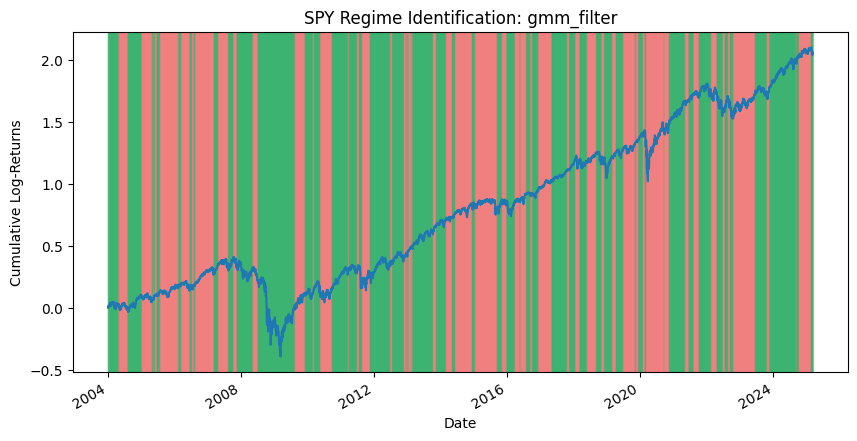

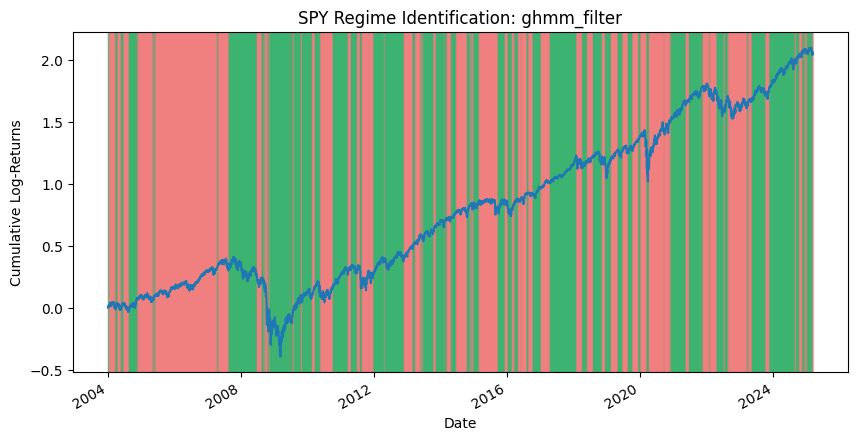

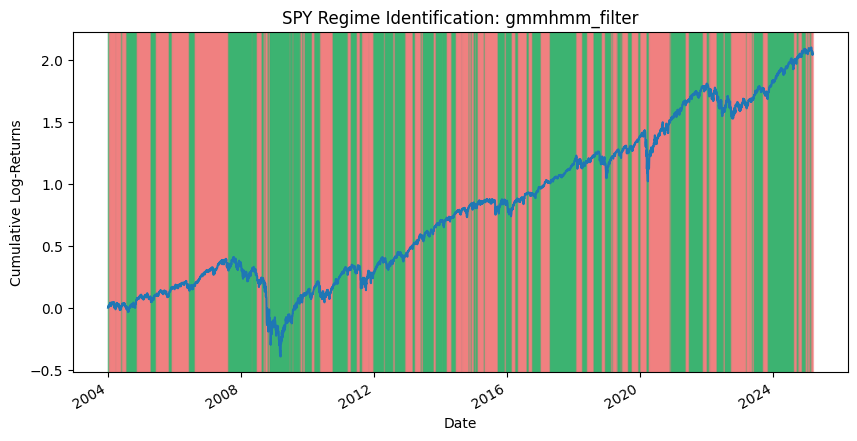

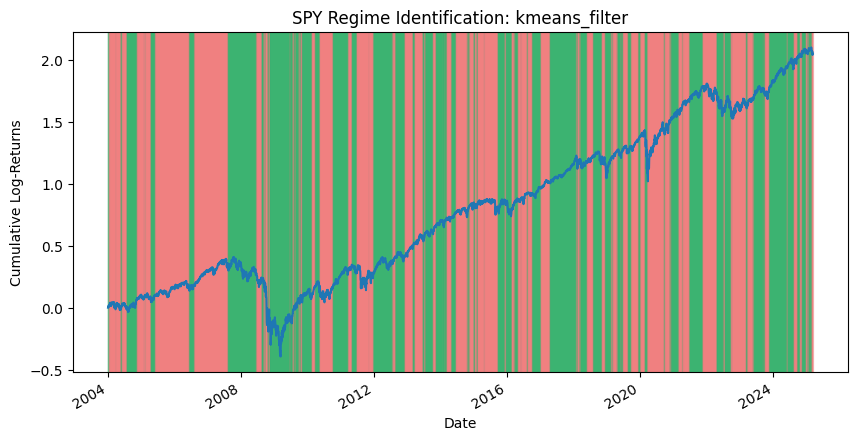

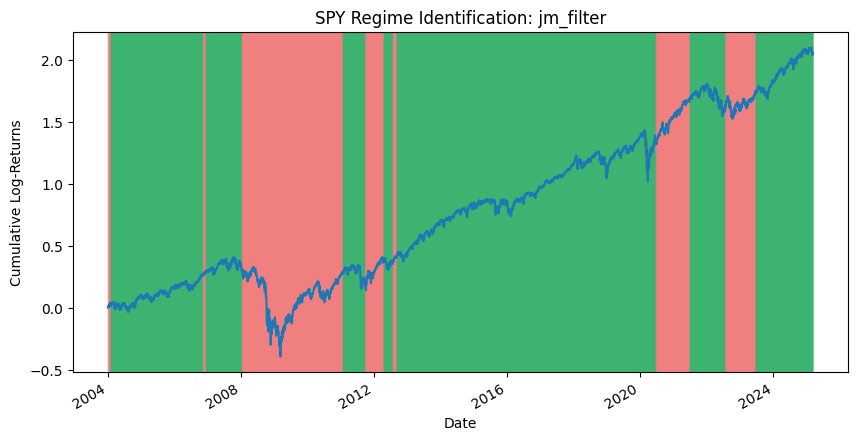

In [420]:
df10 = df6[['SPY', 'gmm_regime', 'ghmm_regime', 'gmmhmm_regime', 'kmeans_regime', 'jm_regime']].copy()
window_size = 30

df10["gmm_filter"] = round(df10["gmm_regime"].rolling(window=window_size, min_periods=1).mean())
df10["ghmm_filter"] = round(df10["ghmm_regime"].rolling(window=window_size, min_periods=1).mean())
df10["gmmhmm_filter"] = round(df10["gmmhmm_regime"].rolling(window=window_size, min_periods=1).mean())
df10["kmeans_filter"] = round(df10["kmeans_regime"].rolling(window=window_size, min_periods=1).mean())
df10["jm_filter"] = round(df10["jm_regime"].rolling(window=window_size, min_periods=1).mean())
df10 = df10.dropna()

df10.index = pd.to_datetime(df10.index)
for column in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

    
    plt.figure(figsize=(10, 5))
    df10['SPY'].cumsum().plot()  
    for i in range(len(df10['SPY']) - 1):
        start_date = df10.index[i]
        end_date = df10.index[i + 1]

        if column in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

            color = 'lightcoral' if df10[column].iloc[i] == 1 else 'mediumseagreen'
        else:
            color = 'lightcoral' if df10[column].iloc[i] == 0 else 'mediumseagreen'

        plt.axvspan(start_date, end_date, color=color, alpha=0.3)
        plt.title(f"SPY Regime Identification: {column}")
        plt.ylabel("Cumulative Log-Returns")

plt.show()




gmm_filter Sharpe: 0.3257549620107909
ghmm_filter Sharpe: 0.5451446188035453
gmmhmm_filter Sharpe: 0.4092253469354153
kmeans_filter Sharpe: 0.29919610959211557
jm_filter Sharpe: 0.46856075509983136
SPY Sharpe: 0.5185891838603587


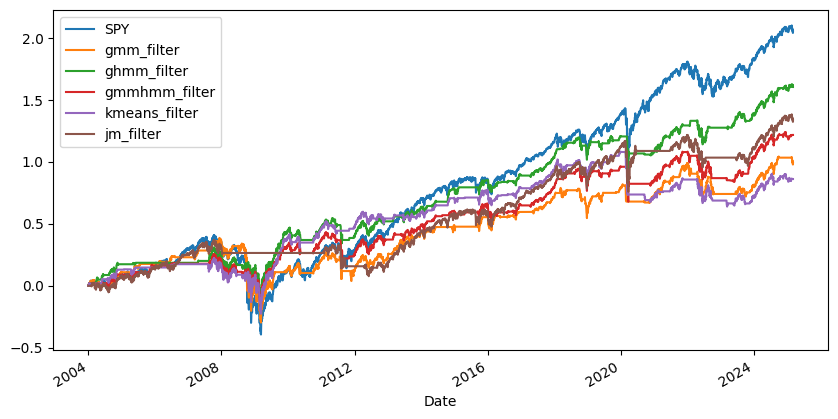

In [421]:
gmm_port = []
port = {i:[] for i in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]}

for i in range(len(df10)):
    for j in port:
        if j in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

            if df10[j].iloc[i] == 0:
                daily_return = df10['SPY'].iloc[i]
            else:
                daily_return = 0 
        else:
            if df10[j].iloc[i] == 1:
                daily_return = df10['SPY'].iloc[i]
            else:
                daily_return = 0 

        port[j].append(daily_return)


port = pd.DataFrame(port, index=df10.index)


# # print("\nPortfolio Returns:")
# # port_results

#df = df.loc["2015-01-01":]
plt.figure(figsize=(10, 5))
#portfolio_results['Portfolio'].cumsum().plot()
df10['SPY'].cumsum().plot()
for i in port.columns:
    port[i].cumsum().plot()
    print(f"{i} Sharpe:", np.sqrt(252) * port[i].mean()/port[i].std())

plt.legend()
print("SPY Sharpe:", np.sqrt(252) * df10['SPY'].mean()/df10['SPY'].std())
plt.show()

In [422]:

df10_5 = df10[["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]].copy()
shifts = []
# gmm_shifts = np.sum(df10_5['GMM_Labels'].diff().abs())
# kmeans_shifts = np.sum(df10_5['KMeans_Labels'].diff().abs())
# JM_shifts = np.sum(df10_5['JM_Labels'].diff().abs())
# GHMM_shifts = np.sum(df10_5['GHMM_Labels'].diff().abs())
# GMMHMM_shifts = np.sum(df10_5['GMMHMM_Labels'].diff().abs())

shifts.append(np.sum(df10_5['gmm_filter'].diff().abs()))
shifts.append(np.sum(df10_5['ghmm_filter'].diff().abs()))
shifts.append(np.sum(df10_5['gmmhmm_filter'].diff().abs()))
shifts.append(np.sum(df10_5['kmeans_filter'].diff().abs()))
shifts.append(np.sum(df10_5['jm_filter'].diff().abs()))

regime_dict = {i:j for i, j in zip(df10_5.columns, shifts)}
regime_dict


{'gmm_filter': 102.0,
 'ghmm_filter': 159.0,
 'gmmhmm_filter': 161.0,
 'kmeans_filter': 167.0,
 'jm_filter': 13.0}

In [423]:
yearly_conversion = len(df10_5) / 252
yearly_regime_dict = {i:j/yearly_conversion for i, j in zip(df10_5.columns, shifts)}
yearly_regime_dict

{'gmm_filter': 4.824324324324325,
 'ghmm_filter': 7.52027027027027,
 'gmmhmm_filter': 7.614864864864865,
 'kmeans_filter': 7.898648648648649,
 'jm_filter': 0.6148648648648649}

In [424]:
average_lengths = df10_5.apply(average_regime_length)
average_lengths

gmm_filter        51.728155
ghmm_filter       33.300000
gmmhmm_filter     32.888889
kmeans_filter     31.714286
jm_filter        380.571429
dtype: float64

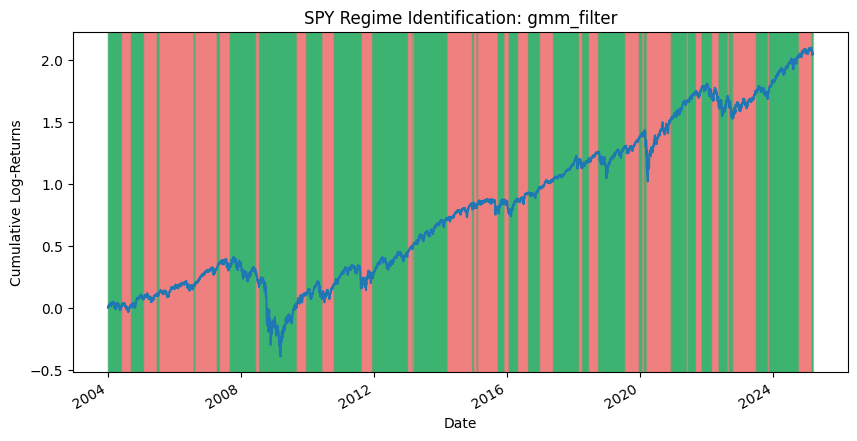

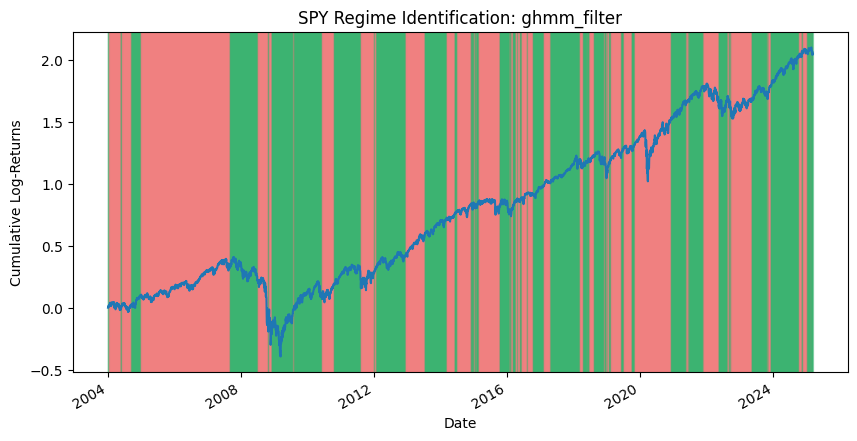

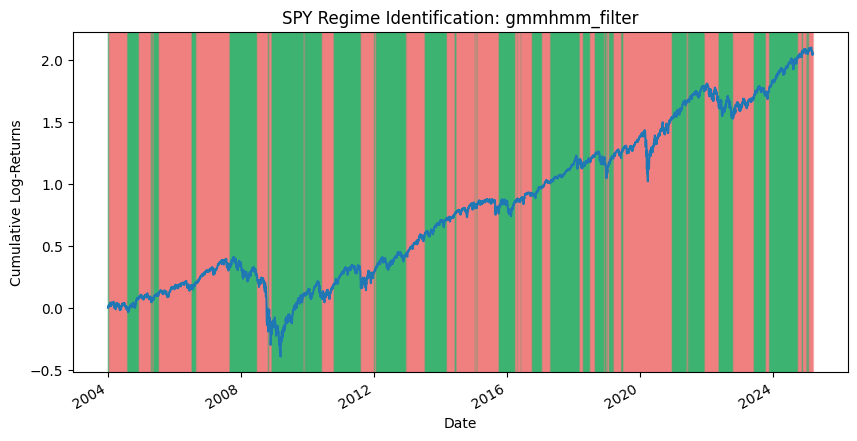

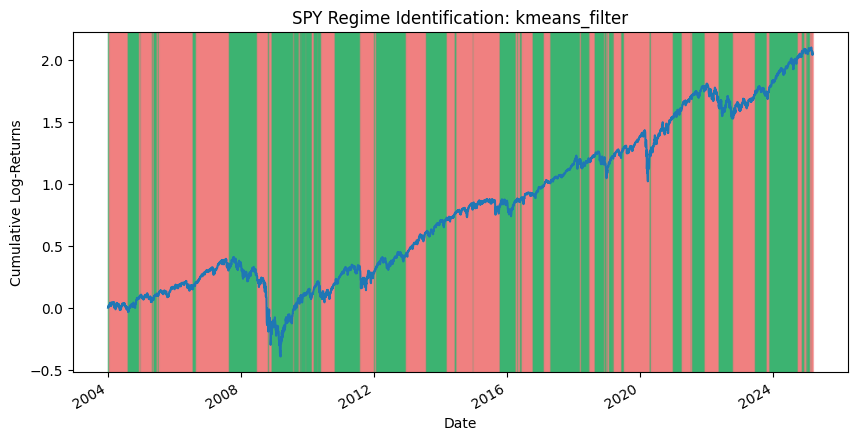

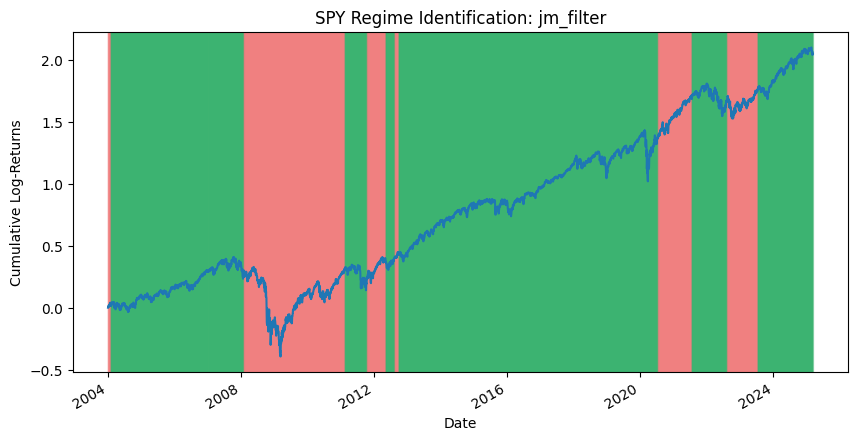

In [425]:
df11 = df6[['SPY', 'gmm_regime', 'ghmm_regime', 'gmmhmm_regime', 'kmeans_regime', 'jm_regime']].copy()
window_size = 60

df11["gmm_filter"] = round(df11["gmm_regime"].rolling(window=window_size, min_periods=1).mean())
df11["ghmm_filter"] = round(df11["ghmm_regime"].rolling(window=window_size, min_periods=1).mean())
df11["gmmhmm_filter"] = round(df11["gmmhmm_regime"].rolling(window=window_size, min_periods=1).mean())
df11["kmeans_filter"] = round(df11["kmeans_regime"].rolling(window=window_size, min_periods=1).mean())
df11["jm_filter"] = round(df11["jm_regime"].rolling(window=window_size, min_periods=1).mean())
df11 = df11.dropna()

df11.index = pd.to_datetime(df11.index)
for column in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

    
    plt.figure(figsize=(10, 5))
    df11['SPY'].cumsum().plot()  
    for i in range(len(df11['SPY']) - 1):
        start_date = df11.index[i]
        end_date = df11.index[i + 1]

        if column in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

            color = 'lightcoral' if df11[column].iloc[i] == 1 else 'mediumseagreen'
        else:
            color = 'lightcoral' if df11[column].iloc[i] == 0 else 'mediumseagreen'

        plt.axvspan(start_date, end_date, color=color, alpha=0.3)
        plt.title(f"SPY Regime Identification: {column}")
        plt.ylabel("Cumulative Log-Returns")

plt.show()




gmm_filter Sharpe: 0.3173932084457486
ghmm_filter Sharpe: 0.5757339700715046
gmmhmm_filter Sharpe: 0.551611138102938
kmeans_filter Sharpe: 0.557480516377723
jm_filter Sharpe: 0.4939703031474964
SPY Sharpe: 0.5185891838603587


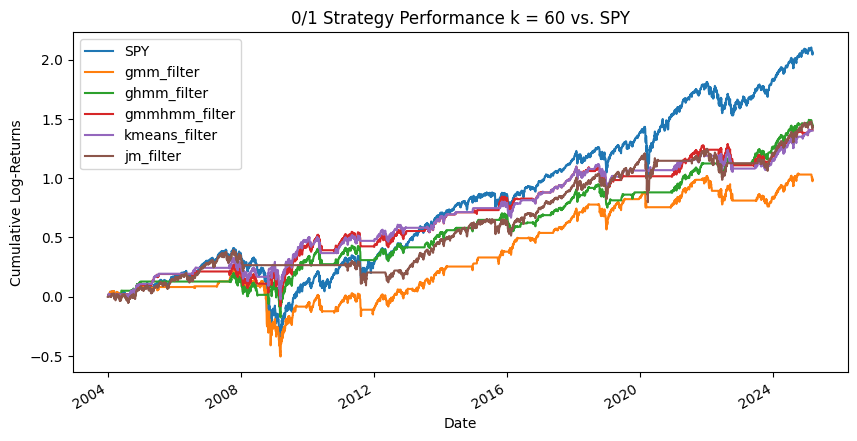

In [426]:
gmm_port = []
port = {i:[] for i in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]}

for i in range(len(df11)):
    for j in port:
        if j in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

            if df11[j].iloc[i] == 0:
                daily_return = df11['SPY'].iloc[i]
            else:
                daily_return = 0 
        else:
            if df11[j].iloc[i] == 1:
                daily_return = df11['SPY'].iloc[i]
            else:
                daily_return = 0 

        port[j].append(daily_return)


port = pd.DataFrame(port, index=df11.index)


# # print("\nPortfolio Returns:")
# # port_results

#df = df.loc["2015-01-01":]
plt.figure(figsize=(10, 5))
plt.ylabel("Cumulative Log-Returns")
plt.title("0/1 Strategy Performance k = 60 vs. SPY")
#portfolio_results['Portfolio'].cumsum().plot()
df11['SPY'].cumsum().plot()
for i in port.columns:
    port[i].cumsum().plot()
    print(f"{i} Sharpe:", np.sqrt(252) * port[i].mean()/port[i].std())

plt.legend()
print("SPY Sharpe:", np.sqrt(252) * df11['SPY'].mean()/df11['SPY'].std())
plt.show()

In [427]:

df11_5 = df11[["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]].copy()
shifts = []
# gmm_shifts = np.sum(df11_5['GMM_Labels'].diff().abs())
# kmeans_shifts = np.sum(df11_5['KMeans_Labels'].diff().abs())
# JM_shifts = np.sum(df11_5['JM_Labels'].diff().abs())
# GHMM_shifts = np.sum(df11_5['GHMM_Labels'].diff().abs())
# GMMHMM_shifts = np.sum(df11_5['GMMHMM_Labels'].diff().abs())

shifts.append(np.sum(df11_5['gmm_filter'].diff().abs()))
shifts.append(np.sum(df11_5['ghmm_filter'].diff().abs()))
shifts.append(np.sum(df11_5['gmmhmm_filter'].diff().abs()))
shifts.append(np.sum(df11_5['kmeans_filter'].diff().abs()))
shifts.append(np.sum(df11_5['jm_filter'].diff().abs()))

regime_dict = {i:j for i, j in zip(df11_5.columns, shifts)}
regime_dict


{'gmm_filter': 62.0,
 'ghmm_filter': 90.0,
 'gmmhmm_filter': 83.0,
 'kmeans_filter': 91.0,
 'jm_filter': 11.0}

In [428]:
yearly_conversion = len(df11_5) / 252
yearly_regime_dict = {i:j/yearly_conversion for i, j in zip(df11_5.columns, shifts)}
yearly_regime_dict

{'gmm_filter': 2.9324324324324325,
 'ghmm_filter': 4.256756756756757,
 'gmmhmm_filter': 3.925675675675676,
 'kmeans_filter': 4.304054054054054,
 'jm_filter': 0.5202702702702703}

In [429]:

average_lengths = df11_5.apply(average_regime_length)
average_lengths


gmm_filter        84.571429
ghmm_filter       58.549451
gmmhmm_filter     63.428571
kmeans_filter     57.913043
jm_filter        444.000000
dtype: float64

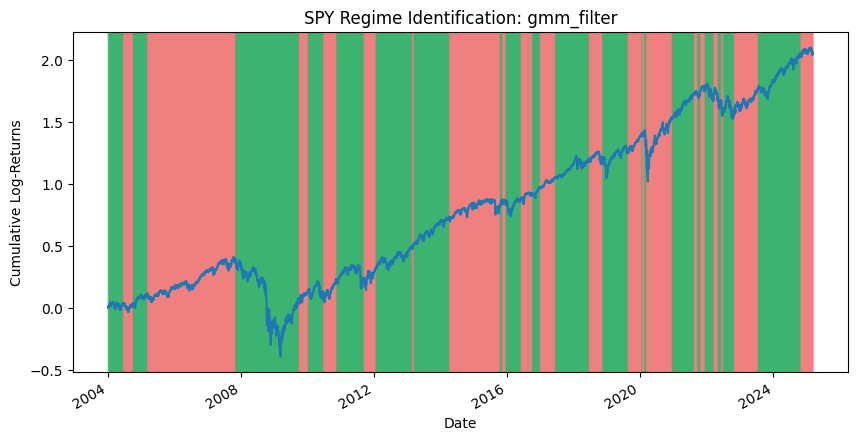

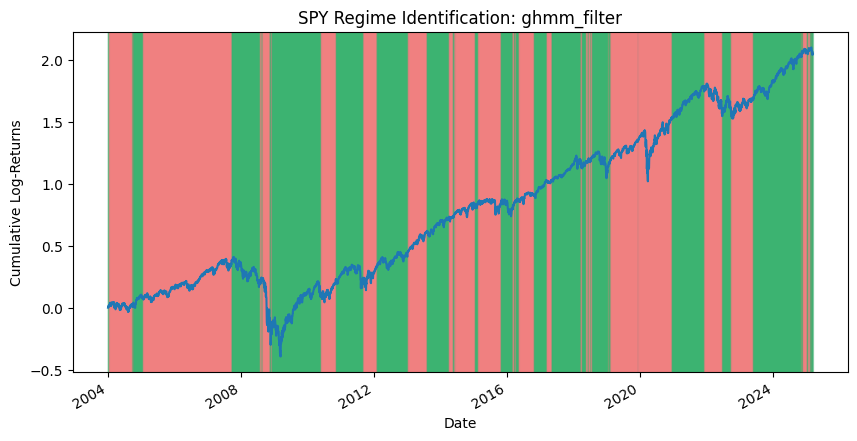

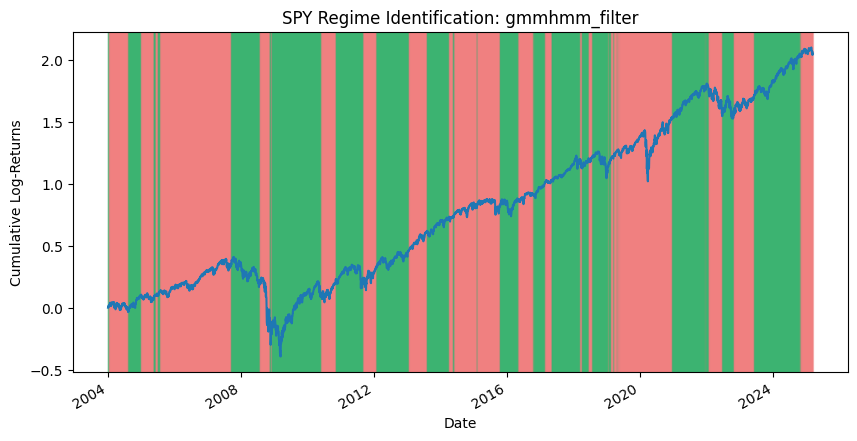

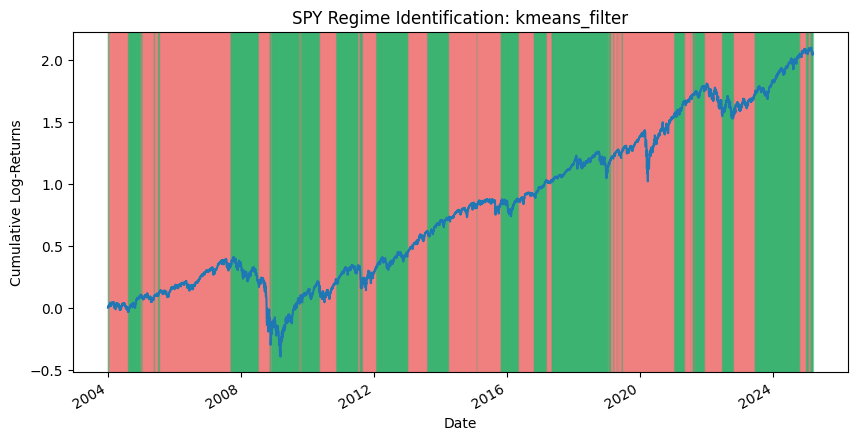

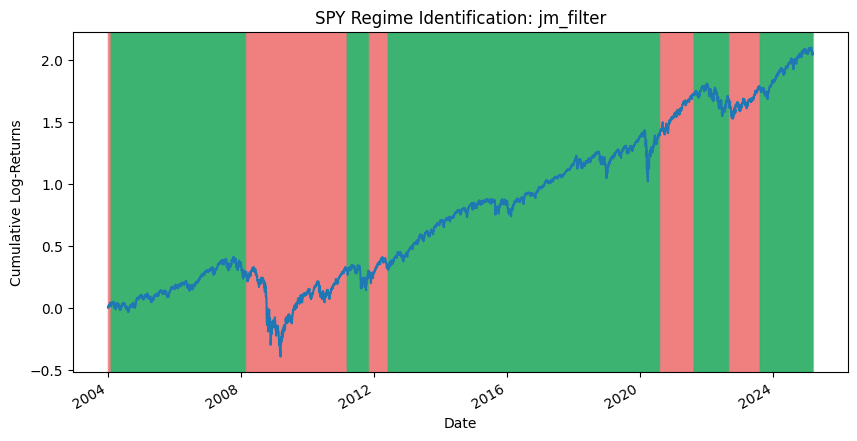

gmm_filter Sharpe: 0.2660150219584708
ghmm_filter Sharpe: 0.4585056522777028
gmmhmm_filter Sharpe: 0.5817440673507815
kmeans_filter Sharpe: 0.4861552653307975
jm_filter Sharpe: 0.4947731753891962
SPY Sharpe: 0.5185891838603587


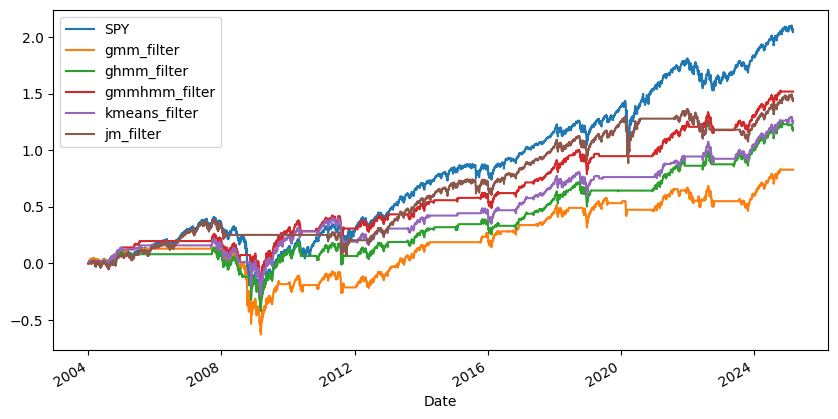

{'gmm_filter': 47.0, 'ghmm_filter': 72.0, 'gmmhmm_filter': 57.0, 'kmeans_filter': 70.0, 'jm_filter': 9.0}
{'gmm_filter': 2.222972972972973, 'ghmm_filter': 3.4054054054054057, 'gmmhmm_filter': 2.695945945945946, 'kmeans_filter': 3.310810810810811, 'jm_filter': 0.4256756756756757}
gmm_filter       111.000000
ghmm_filter       72.986301
gmmhmm_filter     91.862069
kmeans_filter     75.042254
jm_filter        532.800000
dtype: float64


In [430]:
df12 = df6[['SPY', 'gmm_regime', 'ghmm_regime', 'gmmhmm_regime', 'kmeans_regime', 'jm_regime']].copy()
window_size = 90

df12["gmm_filter"] = round(df12["gmm_regime"].rolling(window=window_size, min_periods=1).mean())
df12["ghmm_filter"] = round(df12["ghmm_regime"].rolling(window=window_size, min_periods=1).mean())
df12["gmmhmm_filter"] = round(df12["gmmhmm_regime"].rolling(window=window_size, min_periods=1).mean())
df12["kmeans_filter"] = round(df12["kmeans_regime"].rolling(window=window_size, min_periods=1).mean())
df12["jm_filter"] = round(df12["jm_regime"].rolling(window=window_size, min_periods=1).mean())
df12 = df12.dropna()

df12.index = pd.to_datetime(df12.index)
for column in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

    
    plt.figure(figsize=(10, 5))
    df12['SPY'].cumsum().plot()  
    for i in range(len(df12['SPY']) - 1):
        start_date = df12.index[i]
        end_date = df12.index[i + 1]

        if column in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

            color = 'lightcoral' if df12[column].iloc[i] == 1 else 'mediumseagreen'
        else:
            color = 'lightcoral' if df12[column].iloc[i] == 0 else 'mediumseagreen'

        plt.axvspan(start_date, end_date, color=color, alpha=0.3)
        plt.title(f"SPY Regime Identification: {column}")
        plt.ylabel("Cumulative Log-Returns")

plt.show()

port = {i:[] for i in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]}

for i in range(len(df12)):
    for j in port:
        if j in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

            if df12[j].iloc[i] == 0:
                daily_return = df12['SPY'].iloc[i]
            else:
                daily_return = 0 
        else:
            if df12[j].iloc[i] == 1:
                daily_return = df12['SPY'].iloc[i]
            else:
                daily_return = 0 

        port[j].append(daily_return)


port = pd.DataFrame(port, index=df12.index)


# # print("\nPortfolio Returns:")
# # port_results

#df = df.loc["2015-01-01":]
plt.figure(figsize=(10, 5))
#portfolio_results['Portfolio'].cumsum().plot()
df12['SPY'].cumsum().plot()
for i in port.columns:
    port[i].cumsum().plot()
    print(f"{i} Sharpe:", np.sqrt(252) * port[i].mean()/port[i].std())

plt.legend()
print("SPY Sharpe:", np.sqrt(252) * df12['SPY'].mean()/df12['SPY'].std())
plt.show()

df12_5 = df12[["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]].copy()
shifts = []
# gmm_shifts = np.sum(df12_5['GMM_Labels'].diff().abs())
# kmeans_shifts = np.sum(df12_5['KMeans_Labels'].diff().abs())
# JM_shifts = np.sum(df12_5['JM_Labels'].diff().abs())
# GHMM_shifts = np.sum(df12_5['GHMM_Labels'].diff().abs())
# GMMHMM_shifts = np.sum(df12_5['GMMHMM_Labels'].diff().abs())

shifts.append(np.sum(df12_5['gmm_filter'].diff().abs()))
shifts.append(np.sum(df12_5['ghmm_filter'].diff().abs()))
shifts.append(np.sum(df12_5['gmmhmm_filter'].diff().abs()))
shifts.append(np.sum(df12_5['kmeans_filter'].diff().abs()))
shifts.append(np.sum(df12_5['jm_filter'].diff().abs()))

regime_dict = {i:j for i, j in zip(df12_5.columns, shifts)}
print(regime_dict)

yearly_conversion = len(df12_5) / 252
yearly_regime_dict = {i:j/yearly_conversion for i, j in zip(df12_5.columns, shifts)}
print(yearly_regime_dict)



average_lengths = df12_5.apply(average_regime_length)
print(average_lengths)

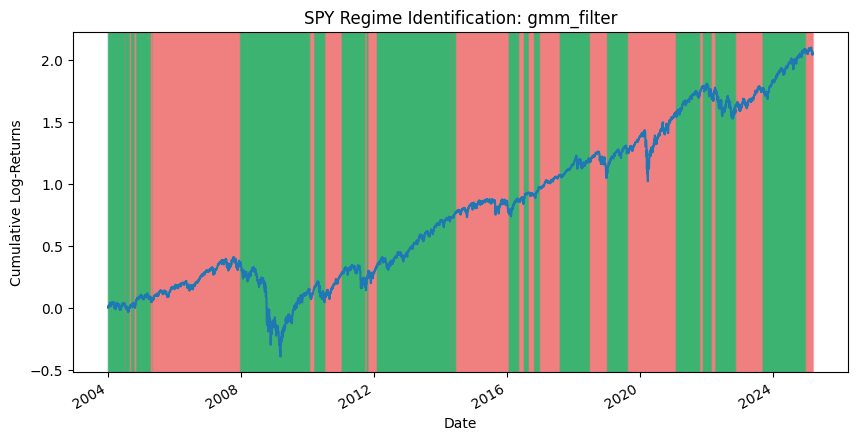

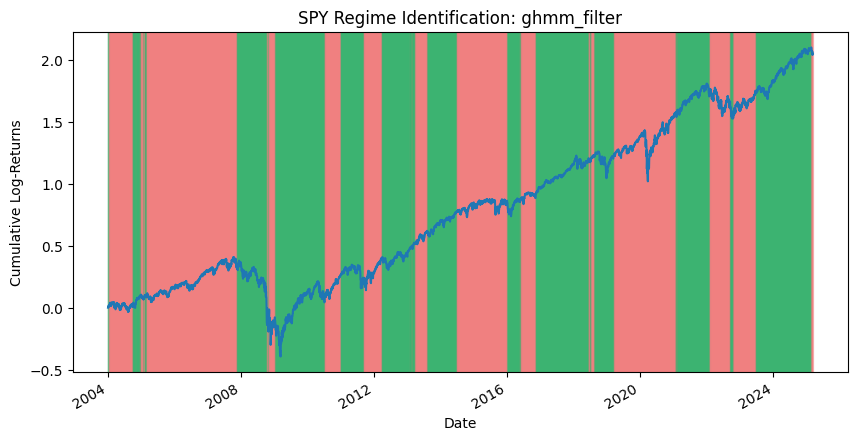

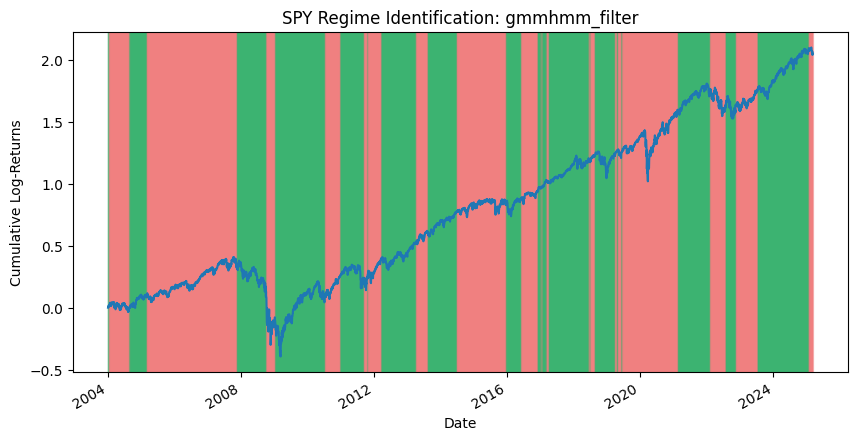

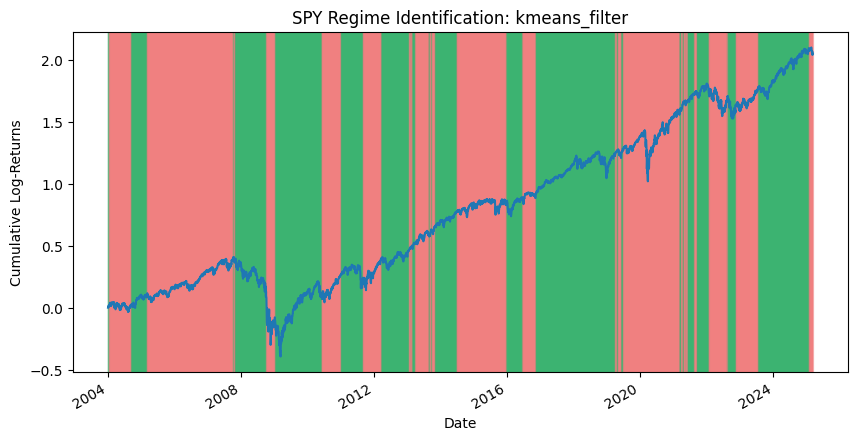

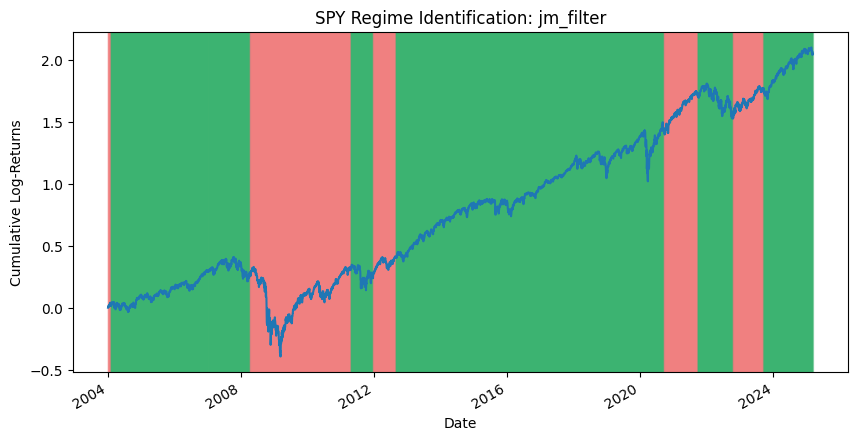

gmm_filter Sharpe: 0.2929701558314467
ghmm_filter Sharpe: 0.3769754381194967
gmmhmm_filter Sharpe: 0.44869043724554075
kmeans_filter Sharpe: 0.40044160384866023
jm_filter Sharpe: 0.45132013569932616
SPY Sharpe: 0.5185891838603587


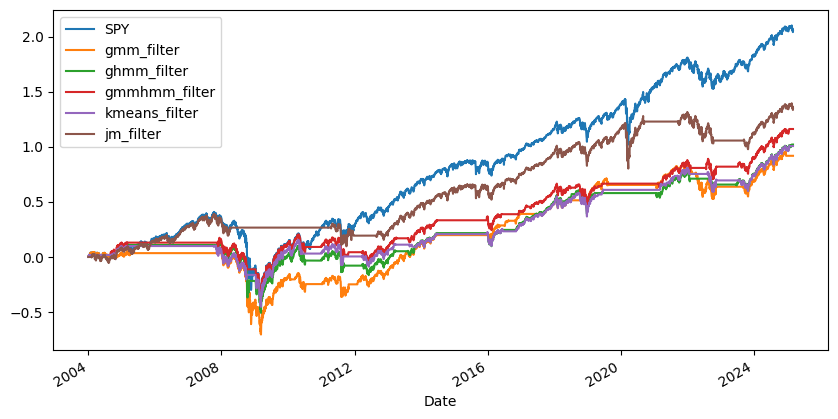

{'gmm_filter': 43.0, 'ghmm_filter': 47.0, 'gmmhmm_filter': 45.0, 'kmeans_filter': 51.0, 'jm_filter': 9.0}
{'gmm_filter': 2.0337837837837838, 'ghmm_filter': 2.222972972972973, 'gmmhmm_filter': 2.1283783783783785, 'kmeans_filter': 2.4121621621621623, 'jm_filter': 0.4256756756756757}
gmm_filter       121.090909
ghmm_filter      111.000000
gmmhmm_filter    115.826087
kmeans_filter    102.461538
jm_filter        532.800000
dtype: float64


In [431]:
df12 = df6[['SPY', 'gmm_regime', 'ghmm_regime', 'gmmhmm_regime', 'kmeans_regime', 'jm_regime']].copy()
window_size = 150

df12["gmm_filter"] = round(df12["gmm_regime"].rolling(window=window_size, min_periods=1).mean())
df12["ghmm_filter"] = round(df12["ghmm_regime"].rolling(window=window_size, min_periods=1).mean())
df12["gmmhmm_filter"] = round(df12["gmmhmm_regime"].rolling(window=window_size, min_periods=1).mean())
df12["kmeans_filter"] = round(df12["kmeans_regime"].rolling(window=window_size, min_periods=1).mean())
df12["jm_filter"] = round(df12["jm_regime"].rolling(window=window_size, min_periods=1).mean())
df12 = df12.dropna()

df12.index = pd.to_datetime(df12.index)
for column in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

    
    plt.figure(figsize=(10, 5))
    df12['SPY'].cumsum().plot()  
    for i in range(len(df12['SPY']) - 1):
        start_date = df12.index[i]
        end_date = df12.index[i + 1]

        if column in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

            color = 'lightcoral' if df12[column].iloc[i] == 1 else 'mediumseagreen'
        else:
            color = 'lightcoral' if df12[column].iloc[i] == 0 else 'mediumseagreen'

        plt.axvspan(start_date, end_date, color=color, alpha=0.3)
        plt.title(f"SPY Regime Identification: {column}")
        plt.ylabel("Cumulative Log-Returns")

plt.show()

port = {i:[] for i in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]}

for i in range(len(df12)):
    for j in port:
        if j in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

            if df12[j].iloc[i] == 0:
                daily_return = df12['SPY'].iloc[i]
            else:
                daily_return = 0 
        else:
            if df12[j].iloc[i] == 1:
                daily_return = df12['SPY'].iloc[i]
            else:
                daily_return = 0 

        port[j].append(daily_return)


port = pd.DataFrame(port, index=df12.index)


# # print("\nPortfolio Returns:")
# # port_results

#df = df.loc["2015-01-01":]
plt.figure(figsize=(10, 5))
#portfolio_results['Portfolio'].cumsum().plot()
df12['SPY'].cumsum().plot()
for i in port.columns:
    port[i].cumsum().plot()
    print(f"{i} Sharpe:", np.sqrt(252) * port[i].mean()/port[i].std())

plt.legend()
print("SPY Sharpe:", np.sqrt(252) * df12['SPY'].mean()/df12['SPY'].std())
plt.show()

df12_5 = df12[["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]].copy()
shifts = []
# gmm_shifts = np.sum(df12_5['GMM_Labels'].diff().abs())
# kmeans_shifts = np.sum(df12_5['KMeans_Labels'].diff().abs())
# JM_shifts = np.sum(df12_5['JM_Labels'].diff().abs())
# GHMM_shifts = np.sum(df12_5['GHMM_Labels'].diff().abs())
# GMMHMM_shifts = np.sum(df12_5['GMMHMM_Labels'].diff().abs())

shifts.append(np.sum(df12_5['gmm_filter'].diff().abs()))
shifts.append(np.sum(df12_5['ghmm_filter'].diff().abs()))
shifts.append(np.sum(df12_5['gmmhmm_filter'].diff().abs()))
shifts.append(np.sum(df12_5['kmeans_filter'].diff().abs()))
shifts.append(np.sum(df12_5['jm_filter'].diff().abs()))

regime_dict = {i:j for i, j in zip(df12_5.columns, shifts)}
print(regime_dict)

yearly_conversion = len(df12_5) / 252
yearly_regime_dict = {i:j/yearly_conversion for i, j in zip(df12_5.columns, shifts)}
print(yearly_regime_dict)



average_lengths = df12_5.apply(average_regime_length)
print(average_lengths)

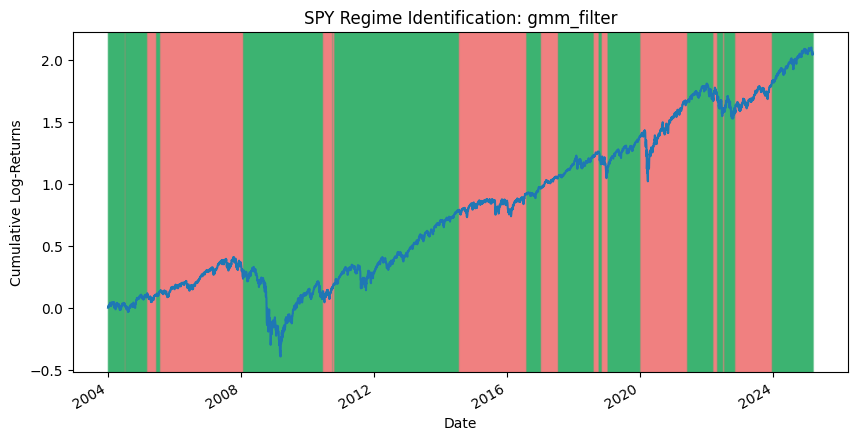

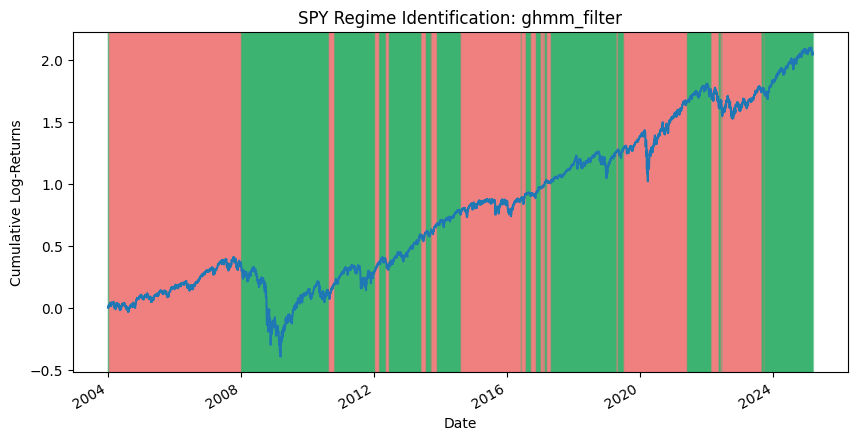

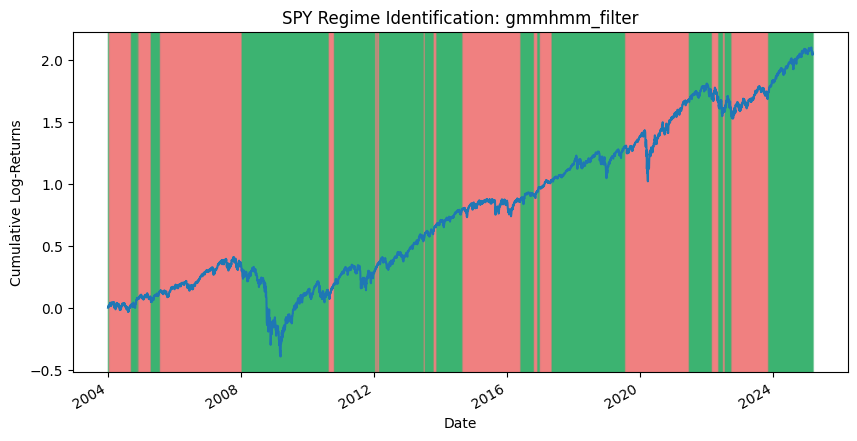

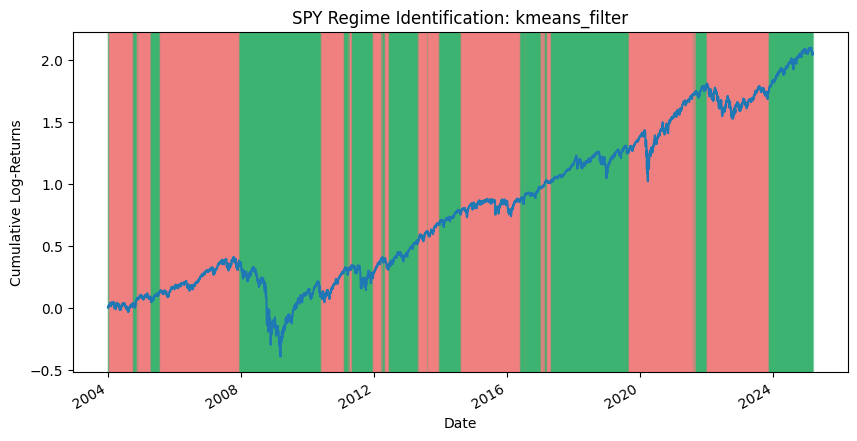

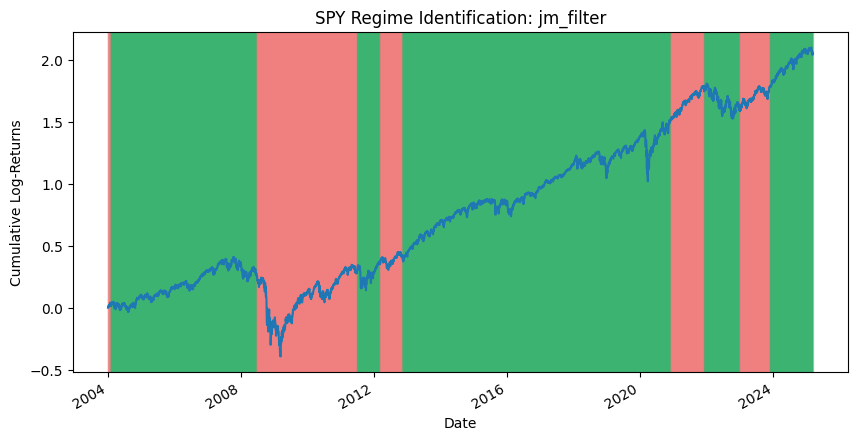

gmm_filter Sharpe: 0.38043803183292635
ghmm_filter Sharpe: 0.2976853366828105
gmmhmm_filter Sharpe: 0.28629191207851556
kmeans_filter Sharpe: 0.25839142961341555
jm_filter Sharpe: 0.5005110563200135
SPY Sharpe: 0.5185891838603587


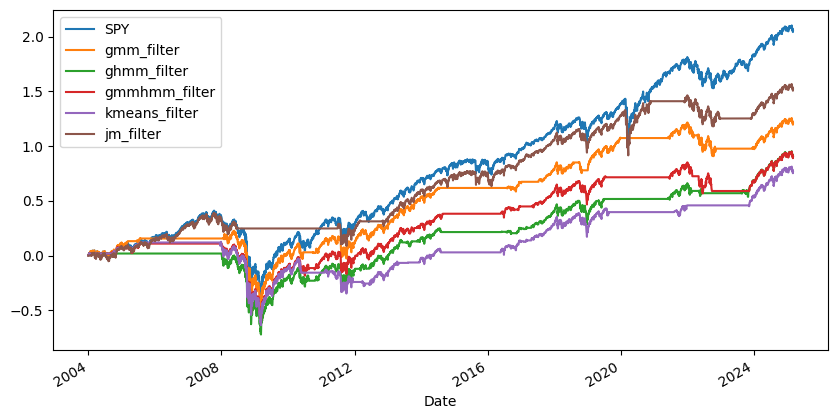

{'gmm_filter': 28.0, 'ghmm_filter': 44.0, 'gmmhmm_filter': 32.0, 'kmeans_filter': 52.0, 'jm_filter': 9.0}
{'gmm_filter': 1.3243243243243243, 'ghmm_filter': 2.081081081081081, 'gmmhmm_filter': 1.5135135135135136, 'kmeans_filter': 2.4594594594594597, 'jm_filter': 0.4256756756756757}
gmm_filter       183.724138
ghmm_filter      118.400000
gmmhmm_filter    161.454545
kmeans_filter    100.528302
jm_filter        532.800000
dtype: float64


In [432]:
df13 = df6[['SPY', 'gmm_regime', 'ghmm_regime', 'gmmhmm_regime', 'kmeans_regime', 'jm_regime']].copy()
window_size = 252

df13["gmm_filter"] = round(df13["gmm_regime"].rolling(window=window_size, min_periods=1).mean())
df13["ghmm_filter"] = round(df13["ghmm_regime"].rolling(window=window_size, min_periods=1).mean())
df13["gmmhmm_filter"] = round(df13["gmmhmm_regime"].rolling(window=window_size, min_periods=1).mean())
df13["kmeans_filter"] = round(df13["kmeans_regime"].rolling(window=window_size, min_periods=1).mean())
df13["jm_filter"] = round(df13["jm_regime"].rolling(window=window_size, min_periods=1).mean())
df13 = df13.dropna()

df13.index = pd.to_datetime(df13.index)
for column in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

    
    plt.figure(figsize=(10, 5))
    df13['SPY'].cumsum().plot()  
    for i in range(len(df13['SPY']) - 1):
        start_date = df13.index[i]
        end_date = df13.index[i + 1]

        if column in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

            color = 'lightcoral' if df13[column].iloc[i] == 1 else 'mediumseagreen'
        else:
            color = 'lightcoral' if df13[column].iloc[i] == 0 else 'mediumseagreen'

        plt.axvspan(start_date, end_date, color=color, alpha=0.3)
        plt.title(f"SPY Regime Identification: {column}")
        plt.ylabel("Cumulative Log-Returns")

plt.show()

port = {i:[] for i in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]}

for i in range(len(df13)):
    for j in port:
        if j in ["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]:

            if df13[j].iloc[i] == 0:
                daily_return = df13['SPY'].iloc[i]
            else:
                daily_return = 0 
        else:
            if df13[j].iloc[i] == 1:
                daily_return = df13['SPY'].iloc[i]
            else:
                daily_return = 0 

        port[j].append(daily_return)


port = pd.DataFrame(port, index=df13.index)


# # print("\nPortfolio Returns:")
# # port_results

#df = df.loc["2015-01-01":]
plt.figure(figsize=(10, 5))
#portfolio_results['Portfolio'].cumsum().plot()
df13['SPY'].cumsum().plot()
for i in port.columns:
    port[i].cumsum().plot()
    print(f"{i} Sharpe:", np.sqrt(252) * port[i].mean()/port[i].std())

plt.legend()
print("SPY Sharpe:", np.sqrt(252) * df13['SPY'].mean()/df13['SPY'].std())
plt.show()

df13_5 = df13[["gmm_filter", "ghmm_filter", "gmmhmm_filter", "kmeans_filter", "jm_filter"]].copy()
shifts = []
# gmm_shifts = np.sum(df13_5['GMM_Labels'].diff().abs())
# kmeans_shifts = np.sum(df13_5['KMeans_Labels'].diff().abs())
# JM_shifts = np.sum(df13_5['JM_Labels'].diff().abs())
# GHMM_shifts = np.sum(df13_5['GHMM_Labels'].diff().abs())
# GMMHMM_shifts = np.sum(df13_5['GMMHMM_Labels'].diff().abs())

shifts.append(np.sum(df13_5['gmm_filter'].diff().abs()))
shifts.append(np.sum(df13_5['ghmm_filter'].diff().abs()))
shifts.append(np.sum(df13_5['gmmhmm_filter'].diff().abs()))
shifts.append(np.sum(df13_5['kmeans_filter'].diff().abs()))
shifts.append(np.sum(df13_5['jm_filter'].diff().abs()))

regime_dict = {i:j for i, j in zip(df13_5.columns, shifts)}
print(regime_dict)

yearly_conversion = len(df13_5) / 252
yearly_regime_dict = {i:j/yearly_conversion for i, j in zip(df13_5.columns, shifts)}
print(yearly_regime_dict)



average_lengths = df13_5.apply(average_regime_length)
print(average_lengths)